In [2]:
%%capture
!pip install -q pulp
!pip install -q kneed

In [3]:
# @title Load data 20 traj

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/new_final/df_20.csv')
# df['person_id'] = (
#     df['person_id'].astype(str)
#     + '_'
#     + df['giro'].astype(str)
# )

df_gt = pd.read_csv('/content/drive/MyDrive/new_final/corr_df_gt_20.csv')
# df_gt['person_id'] = (
#     df_gt['person_id'].astype(str)
#     + '_'
#     + df_gt['giro'].astype(str)
# )
df_gt = df_gt[df_gt['dur'] >= 10]  # discard segments with duration < 10s
exhibits_df = pd.read_csv('/content/drive/MyDrive/new_final/POIs.csv')
# df.to_csv("df_20.csv")
# df_gt.to_csv("df_gt_20.csv")
# exhibits_df.to_csv("POIs.csv")

In [ ]:
# @title Load data 09 traj

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ground_truth_09/tj_all.csv')

df_gt = pd.read_csv('/content/drive/MyDrive/ground_truth_09/gt_stops.csv')

exhibits_df = pd.read_csv('/content/drive/MyDrive/ground_truth_09/POIs.csv')

df.rename(
    columns={
        'time_string': 'time_stamp'
        }, inplace=True
)

df_gt.rename(
    columns={
        'centroid_x_kf': 'x_centroid',
        'centroid_y_kf': 'y_centroid',
        'exhibit': 'gt_poi'
    }, inplace=True
)

exhibits_df['x'] = exhibits_df['x'] / 100
exhibits_df['y'] = exhibits_df['y'] / 100
exhibits_df = exhibits_df.sort_values(by=['name'])

In [4]:
# @title MovMedSpeedSegmenter AND MatchingRetrieverNew

import logging
import math
import os
import time
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
from ipywidgets import HTML, VBox, Layout, HBox, Label, Button, Output, IntText
import ipywidgets as widgets
from IPython.display import display, clear_output
from kneed import KneeLocator
from pulp import *
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist, jensenshannon
from scipy.stats import entropy
from shapely.geometry import Point, MultiLineString
from shapely.wkb import loads


class MovMedSpeedSegmenter:
    """
    Extracts segments from spatio-temporal trajectory data.
    This process requires points of interest (POI) data, including
    positions, to identify the nearest POI to each segment.
    It aggregates consecutive segments associated with the same POI
    in proximity.

    Additional features include plotting capabilities for
    visualizing the speed signal, segments, filtered speed signal,
    and the entropy difference elbow curve over a specified range
    of window lengths for analysis purposes.
    """

    DEFAULT_WINDOW_SIZE = 50  # of moving median (or mean or alpha of ema/ewm)
    DEF_DIST = 20  # distance threshold for Scipy find_peaks()
    DEF_WID = 10  # width threshold for Scipy find_peaks()

    def __init__(self, df, exhibits_df, df_gt=None):
        self.logger = self._setup_logging(level=logging.INFO)
        self.traj_df = df.copy()  # input trajectories dataframe
        self.exhibits_df = exhibits_df.copy()  # POIs dataframe
        self.groundtruth_df = (  #  Groundtruth segments dataframe
            df_gt.copy()
            if df_gt is not None
            else None
        )
        self.final_segments_df = None  # Output segments dataframe
        self.segments_df = None  # Output before merging and duration cut
        self.red_peaks_ = None
        self.blue_peaks_ = None
        self.red_peaks = None
        self.red_heights = None
        self.blue_peaks = None
        self.blue_heights = None
        self.window_size = 0
        self.stats_dict = None

    @staticmethod
    def _setup_logging(level=logging.INFO):
        logger = logging.getLogger("MovMedSpeedSegmenter")
        logger.setLevel(level)

        if logger.handlers:
            for handler in logger.handlers:
                handler.setLevel(level)
                formatter = logging.Formatter("%(levelname)s - %(message)s")
                handler.setFormatter(formatter)
        else:
            ch = logging.StreamHandler()
            ch.setLevel(level)
            formatter = logging.Formatter("%(levelname)s - %(message)s")
            ch.setFormatter(formatter)
            logger.addHandler(ch)

        logger.propagate = False
        return logger

    def process_trajectory_data(self) -> pd.DataFrame:
        """
        1. Adds features to traj_df: mainly "speed"
        2. Sorts, converts timestamps to datetime objects.
        """
        self.stats_df = pd.DataFrame(
            columns=['person_id', 'speed_entr', 'den_speed_entr']
        )

        def _calculate_speed(group):
            group["duration"] = (
                group["time_stamp"]
                .diff()
                .fillna(pd.Timedelta(seconds=0))
                .dt.total_seconds()
            )
            group["distance"] = (
                (
                    (group["x_kf"].shift(-1) - group["x_kf"]) ** 2
                    + (group["y_kf"].shift(-1) - group["y_kf"]) ** 2
                )** 0.5
            ).round(2)
            group["speed"] = (group["distance"] / group["duration"]).round(2)
            group["speed"] = group["speed"].replace(
                [float("inf"), -float("inf")], 0
                )
            return group

        self.logger.info(f"Total rows loaded: {len(self.traj_df)}")

        self.traj_df["time_stamp"] = pd.to_datetime(self.traj_df["time_stamp"])
        self.traj_df = self.traj_df.sort_values(by=["person_id", "time_stamp"])
        self.traj_df["time_stamp"] = pd.to_datetime(self.traj_df["time_stamp"])
        self.traj_df["n_point_id"] = (
            self.traj_df.groupby("person_id").cumcount() + 1
            )
        self.traj_df = self.traj_df.groupby(
            "person_id", group_keys=False
            ).apply(_calculate_speed)

        #  Mark real segments from groundtruth_df in traj_df, column "label"
        #  for visualization purposes. Maybe ML?
        if self.groundtruth_df is not None:
            self.traj_df["label_ground"] = 0
            self.groundtruth_df = self.groundtruth_df.sort_values(
                by=["person_id", "start"]
                )
            self.groundtruth_df["start"] = (
                pd.to_datetime(self.groundtruth_df["start"])
                )
            self.groundtruth_df["end"] = pd.to_datetime(
                self.groundtruth_df["end"]
                )

            for index_gt, row_gt in self.groundtruth_df.iterrows():
                start_time = pd.to_datetime(row_gt["start"])
                end_time = pd.to_datetime(row_gt["end"])
                matching_rows = self.traj_df[
                    (self.traj_df["time_stamp"] >= start_time)
                    & (self.traj_df["time_stamp"] <= end_time)
                    & (self.traj_df["person_id"] == row_gt["person_id"])
                ]
                self.traj_df.loc[matching_rows.index, "label_ground"] = row_gt[
                    "gt_labeling"
                ]

        return self.traj_df.copy()

    def make_stats(self, window):

        def _calculate_jsd(group):

            speed_without_nan = group['speed'].dropna()
            den_speed_without_nan = group['denoised_speed'].dropna()

            hist_speed, _ = np.histogram(
                speed_without_nan, bins=100, density=True
            )
            hist_denoised_speed, _ = np.histogram(
                den_speed_without_nan, bins=100, density=True
            )

            # Normalize the histograms to make sure they sum to 1
            hist_speed /= hist_speed.sum()
            hist_denoised_speed /= hist_denoised_speed.sum()

            jsd = jensenshannon(hist_speed, hist_denoised_speed, base=2)
            return jsd ** 2

        if window >= 0:
          self.traj_df["denoised_speed"] = (
              self.traj_df.groupby("person_id")["speed"]
              .rolling(window=window, center=False)
              .median()
              .reset_index(level=0, drop=True)
          )

        non_zero_den_speed = self.traj_df[
            (self.traj_df['denoised_speed'] != 0)
            & (self.traj_df['denoised_speed'].notna())].copy()

        den_speed_entropy = (non_zero_den_speed.groupby(
            'person_id')['denoised_speed']
            .apply(lambda x: entropy(x, base=2))
        )
        den_speed_std = (
            non_zero_den_speed.groupby("person_id")['denoised_speed'].std()
        )
        non_zero_speed = self.traj_df[
            (self.traj_df['speed'] != 0)
            & (self.traj_df['speed'].notna())].copy()

        speed_entropy = (non_zero_speed.groupby(
            'person_id')['speed']
            .apply(lambda x: entropy(x, base=2))
        )
        speed_std = non_zero_speed.groupby("person_id")['speed'].std()

        temp_df = pd.DataFrame({
            'person_id': speed_entropy.index,
            'speed_entr': speed_entropy.values,
            'speed_std': speed_std,
            'den_speed_entr': den_speed_entropy.values,
            'den_speed_std': den_speed_std,
            'x_std': speed_std - den_speed_std,
            'x_entr': speed_entropy.values - den_speed_entropy.values,
            'window': window,
        })

        jsd_values = non_zero_speed.groupby('person_id').apply(_calculate_jsd)
        temp_df['x_jsd'] = temp_df['person_id'].map(jsd_values)

        if self.stats_df is None:
            self.stats_df = temp_df.copy()
        else:
            self.stats_df = pd.concat(
                [self.stats_df.copy(), temp_df.copy()], ignore_index=True
            )
            self.stats_df = self.stats_df.sort_values(
            by=["person_id", "window"]
            )

    def jsd_elbow_curve(self, min, max, step, plot=False):

        window_sizes = range(min, max + step, step)
        [self.make_stats(window_size) for window_size in window_sizes]

        self.elbow_points_df = pd.DataFrame()

        for person_id, group in self.stats_df.groupby('person_id'):
            x = group['window']
            y_jsd = group['x_jsd']

            if len(x) > 1 and len(y_jsd) > 1:
                slopes_jsd = np.diff(y_jsd) / np.diff(x)
                kneedle_jsd = KneeLocator(
                    x[:-1], slopes_jsd, curve='convex', direction='decreasing'
                )
                elbow_jsd = kneedle_jsd.elbow

                if elbow_jsd is not None:
                    elbow_jsd_index = np.where(x[:-1] == elbow_jsd)[0][0]
                    elbow_jsd_y = y_jsd.iloc[elbow_jsd_index]
                else:
                    elbow_jsd_y = np.nan

                if plot:
                    plt.figure(figsize=(12, 6))
                    plt.plot(x, y_jsd, label='JSD')
                    plt.xlabel('Window Size')
                    plt.ylabel('Jensen-Shannon Divergence')
                    plt.title(f'JSD Curve for {person_id}')
                    plt.legend()
                    plt.xticks(window_sizes)
                    plt.grid(True)
                    if elbow_jsd is not None:
                        plt.scatter(
                            elbow_jsd, elbow_jsd_y,
                            color='red', label='Elbow Point'
                        )
                    plt.show()

                self.elbow_points_df = self.elbow_points_df.append({
                    'person_id': person_id,
                    'jsd_elbow': elbow_jsd
                }, ignore_index=True)

            else:
                self.logger.info(
                    f"Not enough data points for {person_id}"
                    "to determine JSD elbow."
                )

        if not self.elbow_points_df.empty:
            mean_jsd_elbow = self.elbow_points_df['jsd_elbow'].mean()
            self.logger.info(
                f"Average JSD elbow across all individuals: {mean_jsd_elbow}"
            )
        else:
            self.logger.info("No JSD elbow points were calculated.")

        return self.elbow_points_df.copy()

    def find_elbows(self, min, max, step, measure="entr", plot=False):
        window_sizes = range(min, max + step, step)
        [self.make_stats(window_size) for window_size in window_sizes]

        elbow_points_data = []

        for person_id, df_group in self.stats_df.groupby("person_id"):
            x = df_group['window']
            if measure == "std":
                y1 = (1 * df_group['x_std'])
                label_t = "Standard Deviation"
            elif measure == "entr":
                y1 = (-1 * df_group['x_entr'])
                label_t = "Entropy"
            else:
                y1 = (-1 * df_group['x_entr'])
                label_t = "Entropy"

            slopes1 = np.diff(y1) / np.diff(x)

            kneedle_first = KneeLocator(
                x[:-1], slopes1, curve='convex', direction='decreasing'
            )
            first_elbow = kneedle_first.elbow

            first_elbow_y = (
                y1[x == first_elbow].iloc[0]
                if first_elbow is not None
                else np.nan
            )

            if first_elbow is not None:
                first_elbow_index = np.where(x == first_elbow)[0][0]
                x_new_segment = x[first_elbow_index + 1:]
                y1_new_segment = y1[first_elbow_index + 1:]
                slopes2 = np.diff(y1_new_segment) / np.diff(x_new_segment)

                if len(x_new_segment) > 1 and len(y1_new_segment) > 1:
                    kneedle_second = KneeLocator(
                        x_new_segment[:-1], slopes2,
                        curve='convex', direction='decreasing'
                    )
                    second_elbow = kneedle_second.elbow
                    second_elbow_y = (
                        y1[x == second_elbow].iloc[0]
                        if second_elbow is not None
                        else np.nan
                    )
                else:
                    second_elbow = None
                    second_elbow_y = np.nan
            else:
                second_elbow = None
                second_elbow_y = np.nan
            elbows = [
                val for val in [first_elbow, second_elbow]
                if val is not None
            ]
            mean_elbow = np.mean(elbows) if elbows else None

            elbow_points_data.append({
                'person_id': person_id,
                'first_elbow': first_elbow,
                'second_elbow': second_elbow,
                'mean_elbow': mean_elbow,
                'first_elbow_y': first_elbow_y,
                'second_elbow_y': second_elbow_y,
                'mean_x_entr': np.mean([first_elbow_y, second_elbow_y])
            })

            if plot:
                if measure == "std":
                    plt.figure(figsize=(12, 6))
                    plt.plot(x, -y1, label=f'{label_t} Difference')
                    plt.xlabel('Window Size', fontsize=18)
                    plt.ylabel(f'{measure} Difference', fontsize=18)
                    plt.title(f'{label_t} Curve; Trajectory: {person_id}', fontsize=18)
                    plt.xticks(np.arange(min, max, step))
                    plt.grid(True)
                    if first_elbow is not None:
                        plt.scatter(
                            first_elbow, -first_elbow_y,
                            color='red', label='First Elbow Point'
                        )
                    if second_elbow is not None:
                        plt.scatter(
                            second_elbow, -second_elbow_y,
                            color='green', label='Elbow Point'
                        )
                    plt.legend(fontsize=18)
                    plt.show()

                else:
                    plt.figure(figsize=(12, 6))
                    plt.plot(x, y1, label=f'{label_t} Difference')
                    plt.xlabel('Window Size', fontsize=18)
                    plt.ylabel(f'{measure} Difference', fontsize=18)
                    plt.title(f'{label_t} Curve; Trajectory: {person_id}', fontsize=18)
                    plt.xticks(np.arange(min, max, step))
                    plt.grid(True)
                    if first_elbow is not None:
                        plt.scatter(
                            first_elbow, first_elbow_y,
                            color='red', label='First Elbow Point'
                        )
                    if second_elbow is not None:
                        plt.scatter(
                            second_elbow, second_elbow_y,
                            color='green', label='Elbow Point'
                        )
                    plt.legend(fontsize=18)
                    plt.show()

        self.elbow_points_df = pd.DataFrame(elbow_points_data)

        self.logger.info("Suggested alphas: ")
        self.logger.info(
            f"First elbow: {self.elbow_points_df['first_elbow_y'].mean()}"
        )
        self.logger.info(
            f"Mid elbow: {self.elbow_points_df['mean_x_entr'].mean()}"
        )
        self.logger.info(
            f"Second elbow: {self.elbow_points_df['second_elbow_y'].mean()}"
        )

    def optimal_window_filter(
        self, alpha: Union[float, str] = 0.3, def_window=30):

        if alpha == 'auto':
            if 'person_id' in self.elbow_points_df.columns:
                self.elbow_points_df.set_index('person_id', inplace=True)

            self.x_entr_crossing_df = (
                self.elbow_points_df[['second_elbow']]
                .rename(columns={'second_elbow': 'window'})
            )
            self.x_entr_crossing_df['window'] = (
                self.x_entr_crossing_df['window']
                .fillna(def_window).astype(int)
            )
            for person_id in self.traj_df['person_id'].unique():
                if person_id in self.elbow_points_df.index:
                    window_size = (
                        self.elbow_points_df.loc[person_id, 'second_elbow']
                    )
                    if pd.notnull(window_size):
                        denoised_speed = (
                            self.traj_df.loc[
                                self.traj_df['person_id'] == person_id, 'speed'
                            ].rolling(window=int(window_size), center=False)
                            .median()
                        )
                        self.traj_df.loc[
                            self.traj_df['person_id'] == person_id,
                            'denoised_speed'
                            ] = denoised_speed

        else:
            x_entr_crossing_data = []

            for person_id, df_group in self.stats_df.groupby("person_id"):
                x = df_group['window']
                y = df_group['x_std']
                y1 = -1 * df_group['x_entr']

                crossing_index = np.argmax(y1 >= alpha)
                crossing_window = (
                    x.iloc[crossing_index]
                    if crossing_index < len(x)
                    else None
                    )
                crossing_entr = (
                    -df_group['x_entr'].iloc[crossing_index]
                    if crossing_index < len(x)
                    else None
                    )

                x_entr_crossing_data.append({
                    'person_id': person_id,
                    'window': crossing_window,
                    'x_entr': crossing_entr
                })
            self.x_entr_crossing_df = pd.DataFrame(x_entr_crossing_data)
            self.x_entr_crossing_df = (
                pd.DataFrame(x_entr_crossing_data)
                .set_index('person_id')
                )
            self.x_entr_crossing_df['window'] = (
                self.x_entr_crossing_df['window']
                .fillna(def_window).astype(int)
                )
            for person_id in self.traj_df['person_id'].unique():
                if person_id in self.x_entr_crossing_df.index:
                    window_size = (
                        self.x_entr_crossing_df.loc[person_id, 'window']
                    )
                    if pd.notnull(window_size):
                        denoised_speed = (
                            self.traj_df.loc[
                                self.traj_df['person_id'] == person_id, 'speed'
                                ].rolling(window=window_size, center=False)
                                .median()
                        )
                    else:
                        denoised_speed = (
                            self.traj_df.loc[
                                self.traj_df['person_id'] == person_id, 'speed'
                                ].rolling(window=def_window, center=False)
                                .median()
                        )
                    self.traj_df.loc[
                        self.traj_df['person_id'] == person_id,
                        'denoised_speed'
                        ] = denoised_speed

    def scipy_peaks_plot(
        self, real=False, tol=1.95, steep=0.1,
        x1_=None, x2_=None, y1_=None, y2_=None, figg=(30, 10)):

        """
        1. Choose parameters looking at the graph per each user.
        2. Overlay extracted segments on the graph
        3. Set duration cut-off and export to .csv file

        """
        segments_found = False
        median_seg = False
        unique_person_ids = self.traj_df["person_id"].unique().tolist()

        dropdown = widgets.Dropdown(
            options=unique_person_ids,
            value=unique_person_ids[0] if unique_person_ids else None,
            description="Trajectory ID:",
        )
        dropdown.layout = Layout(margin="15px 0 15px 0")
        window_size_slider = widgets.IntSlider(
            value=20,
            min=1,
            max=200,
            step=5,
            description="Window Size:",
            layout=widgets.Layout(width="20%"),
        )
        height_slider = widgets.FloatSlider(
            value=-0.8,
            min=-1.2,
            max=1.0,
            step=0.1,
            description="Height:",
            layout=widgets.Layout(width="40%"),
        )
        prom_slider = widgets.FloatSlider(
            value=None,
            min=-2.0,
            max=2.0,
            step=0.01,
            description="Prominence:",
            layout=widgets.Layout(width="40%"),
        )
        dist_slider = widgets.IntSlider(
            value=MovMedSpeedSegmenter.DEF_DIST,
            min=1,
            max=200,
            step=1,
            description="Distance:",
            layout=widgets.Layout(width="40%"),
        )
        wid_slider = widgets.IntSlider(
            value=MovMedSpeedSegmenter.DEF_WID,
            min=1,
            max=100,
            step=1,
            description="Width:",
            layout=widgets.Layout(width="40%"),
        )
        height_slider1 = widgets.FloatSlider(
            value=0.3,
            min=-1.2,
            max=1.0,
            step=0.1,
            description="Height1:",
            layout=widgets.Layout(width="40%"),
        )
        prom_slider1 = widgets.FloatSlider(
            value=None,
            min=-2.0,
            max=2.0,
            step=0.01,
            description="Prominence1:",
            layout=widgets.Layout(width="40%"),
        )
        dist_slider1 = widgets.IntSlider(
            value=MovMedSpeedSegmenter.DEF_DIST,
            min=1,
            max=200,
            step=1,
            description="Distance1:",
            layout=widgets.Layout(width="40%"),
        )
        wid_slider1 = widgets.IntSlider(
            value=MovMedSpeedSegmenter.DEF_WID,
            min=1,
            max=100,
            step=1,
            description="Width1:",
            layout=widgets.Layout(width="40%"),
        )

        # btn_find_segments = Button(description='Find Segments')
        btn_export_csv = Button(description="Export to CSV")
        btn_find_segments_med = Button(description="Initial Segments")
        btn_club_segments_med = Button(description="Merge segments")
        btn_refine_segments_med = Button(description="Refine ends")
        btn_find_segments = Button(description="[AUTO] Find Segments")


        plot_output = Output()
        output = Output()

        duration_text = IntText(
            value=10,
            description="Duration:",
            disabled=False,
            style={"description_width": "initial"},
        )

        def _label_do():
            self.traj_df["label_estim"] = 0
            if self.final_segments_df is None:
                for _, segment in self.segments_df.iterrows():

                    segment_range1 = (
                        (self.traj_df["person_id"] == segment["person_id"])
                        & (self.traj_df["n_point_id"] >= segment["start_id"])
                        & (self.traj_df["n_point_id"] <= segment["end_id"])
                    )
                    self.traj_df.loc[
                        segment_range1, "label_estim"
                        ] = segment["label"]

            else:
                for _, segment in self.final_segments_df.iterrows():

                    segment_range1 = (
                        (self.traj_df["person_id"] == segment["person_id"])
                        & (self.traj_df["n_point_id"] >= segment["start_id"])
                        & (self.traj_df["n_point_id"] <= segment["end_id"])
                    )
                    self.traj_df.loc[
                        segment_range1, "label_estim"
                        ] = segment["label"]

        def _on_export_csv_click(_):
            if self.final_segments_df is None:
                self.logger.info("Find the segments first!")
            else:
                self.export_segments_csv()

        def _on_find_segments_median_click(_):
            nonlocal segments_found
            nonlocal median_seg
            with output:
                clear_output()
                segments_found = True
                window_size = window_size_slider.value
                self.segment_graph("median", window_size)
                _label_do()
                median_seg = True
                _update_plot()

        def _on_club_segments_click(_):
            nonlocal segments_found
            nonlocal median_seg
            with output:
                clear_output()
                segments_found = True
                self.closest_POI_from_geom()
                self.merge_segments_df()
                # duration = max(0, duration_text.value)
                # self.discard_short_segments(duration)
                _label_do()
                median_seg = True
                _update_plot()

        def _on_refine_segments_click(_):
            nonlocal segments_found
            nonlocal median_seg
            with output:
                segments_found = True
                self.refine_end_segment_boundaries(tol)
                # self.refine_start_segment_boundaries(2.1)
                _label_do()
                median_seg = True
                _update_plot()

        def _on_find_segments_click(_):
            nonlocal segments_found
            nonlocal median_seg
            with output:
                segments_found = True
                window_size = window_size_slider.value
                self.segment_graph("median", window_size)
                self.closest_POI_from_geom()
                duration = max(0, duration_text.value)
                self.merge_segments_df()
                self.refine_end_segment_boundaries(tol)
                self.discard_short_segments(duration)
                # self.refine_start_segment_boundaries(2.1)
                _label_do()
                median_seg = True
                _update_plot()

        def _update_plot(change=None):
            nonlocal segments_found
            nonlocal median_seg
            nonlocal x1_, x2_, y1_, y2_, figg
            with plot_output:
                plot_output.clear_output()
                selected_person_id = dropdown.value
                window_size = window_size_slider.value
                h = height_slider.value
                prom = prom_slider.value
                dist = dist_slider.value
                wid = wid_slider.value
                h1 = height_slider1.value
                p1 = prom_slider1.value
                d1 = dist_slider1.value
                w1 = wid_slider1.value

                if real:
                    fig, (ax, ax1) = plt.subplots(2, 1, figsize=(60, 20))
                else:
                    fig = plt.figure(figsize=figg)
                    ax = fig.add_subplot(1, 1, 1)

                if median_seg is False:
                    self.traj_df["denoised_speed"] = (
                        self.traj_df.groupby("person_id")["speed"]
                        .rolling(window=window_size, center=False)
                        .median()
                        .reset_index(level=0, drop=True)
                    )

                    selected_df = self.traj_df[
                        self.traj_df["person_id"] == selected_person_id
                    ]

                    x = selected_df["n_point_id"]
                    y = selected_df["denoised_speed"]

                    ax.plot(x, y, label="mov_med_speed", color="green")

                    if real:
                        if (self.groundtruth_df is not None):
                            ax1.plot(x, y, label="mov_med_speed", color="green")
                            mask1 = selected_df["label_ground"] != 0
                            y2 = np.where(mask1, y, np.nan)
                            ax1.plot(x, y2, label="Ground truth segments", c="red")
                        else:
                            self.logger.info(
                                f"Ground truth was not initialized."
                            )


                    self.find_steep_decreases()

                    # Find peaks and valleys for the selected person_id
                    selected_person_id = dropdown.value
                    selected_df = self.traj_df[self.traj_df["person_id"] == selected_person_id]

                    peaks1 = scipy.signal.find_peaks(
                        -selected_df["denoised_speed"],
                        height=-self.height_threshold_df.loc[
                            self.height_threshold_df['person_id'] == selected_person_id,
                            'height'].values[0],
                        distance=MovMedSpeedSegmenter.DEF_DIST,
                        width=MovMedSpeedSegmenter.DEF_WID,)

                    peaks2 = scipy.signal.find_peaks(
                        selected_df["denoised_speed"],
                        height=self.height_threshold_df.loc[
                            self.height_threshold_df['person_id'] == selected_person_id,
                            'height'].values[0],
                        distance=MovMedSpeedSegmenter.DEF_DIST,
                        width=MovMedSpeedSegmenter.DEF_WID,)

                    peak_pos1 = peaks1[0]
                    heights1 = peaks1[1]["peak_heights"]

                    peak_pos2 = peaks2[0]
                    heights2 = peaks2[1]["peak_heights"]

                    ax.scatter(
                        selected_df["n_point_id"].iloc[peak_pos1],
                        -heights1,
                        color="blue",
                        s=30,
                        marker="x",
                        label="Valleys",
                    )
                    ax.scatter(
                        selected_df["n_point_id"].iloc[peak_pos2],
                        heights2,
                        color="red",
                        s=30,
                        marker="o",
                        label="Peaks",
                    )

                    if segments_found:
                        mask = selected_df["label"] != 0
                        y1 = np.where(mask, y, np.nan)

                        ax.plot(x, y1, label="Detected segments", c="#ffbe0b")

                    blue_line_y = (
                        self.height_threshold_df.loc[
                            self.height_threshold_df['person_id']
                            == selected_person_id]
                            ['height'].values[0]
                    )

                    ax.axhline(
                        y=blue_line_y,
                        color="blue",
                        linewidth=1.3,
                        label="height threshold",
                    )

                else:
                    self.logger.info(
                        "Plotting..."
                    )
                    self.traj_df["denoised_speed"] = (
                        self.traj_df.groupby("person_id")["speed"]
                        .rolling(window=window_size, center=False)
                        .median()
                        .reset_index(level=0, drop=True)
                    )
                    selected_df = self.traj_df[
                        self.traj_df["person_id"] == selected_person_id
                    ]
                    x = selected_df["n_point_id"]
                    y = selected_df["denoised_speed"]

                    ax.plot(x, y, label="mov_med_speed", color="green")



                    if real:
                        if (self.groundtruth_df is not None):
                            ax1.plot(x, y, label="mov_med_speed", color="green")
                            mask1 = selected_df["label_ground"] != 0
                            y2 = np.where(mask1, y, np.nan)
                            ax1.plot(x, y2, label="Ground truth segments", c="red")
                        else:
                            self.logger.info(
                                f"Ground truth was not initialized."
                            )

                        self.red_peaks_ = self.traj_df.groupby("person_id").apply(
                            lambda x: scipy.signal.find_peaks(
                                x["denoised_speed"],
                                # height=x["denoised_speed"].median(),
                                height=self.height_threshold_df.loc[
                                    self.height_threshold_df['person_id'] == x.name,
                                    'height'].values[0],
                                distance=MovMedSpeedSegmenter.DEF_DIST,
                                width=MovMedSpeedSegmenter.DEF_WID,)
                        )

                    self.red_peaks = self.red_peaks_.apply(lambda x: x[0])
                    self.red_heights = self.red_peaks_.apply(lambda x: x[1])

                    self.blue_peaks_ = self.traj_df.groupby("person_id").apply(
                        lambda x: scipy.signal.find_peaks(
                            -x["denoised_speed"],
                            height=-self.height_threshold_df.loc[
                                self.height_threshold_df['person_id'] == x.name,
                                'height'].values[0],
                            distance=MovMedSpeedSegmenter.DEF_DIST,
                            width=MovMedSpeedSegmenter.DEF_WID,
                        )
                    )

                    self.blue_peaks = self.blue_peaks_.apply(lambda x: x[0])
                    self.blue_heights = self.blue_peaks_.apply(lambda x: x[1])
                    peak_pos_blue = self.blue_peaks[selected_person_id]
                    heights_blue = (
                        self.blue_heights[selected_person_id]["peak_heights"]
                        )

                    peak_pos_red = self.red_peaks[selected_person_id]
                    heights_red = (
                        self.red_heights[selected_person_id]["peak_heights"]
                    )

                    ax.scatter(
                        peak_pos_blue,
                        -heights_blue,
                        color="blue",
                        s=30,
                        marker="x",
                        label="Valleys",
                    )
                    ax.scatter(
                        peak_pos_red,
                        heights_red,
                        color="red",
                        s=30,
                        marker="o",
                        label="Peaks",
                    )
                    if segments_found:
                        mask = selected_df["label_estim"] != 0
                        y1 = np.where(
                            mask,
                            selected_df["denoised_speed"],
                            np.nan
                            )

                        ax.plot(x, y1, label="Detected segments", c="#ffbe0b")

                        # if (self.red_heights is not None and
                        #         not self.red_heights.empty):
                        #     blue_line_y = np.median(self.red_heights[
                        #         selected_df["person_id"].iloc[0]
                        #         ]["peak_heights"]
                        #     )
                        #     red_line_y = selected_df["denoised_speed"].median()
                        if (self.red_heights is not None and
                                not self.red_heights.empty):
                            blue_line_y = (
                                self.height_threshold_df.loc[
                                    self.height_threshold_df['person_id']
                                    == selected_person_id]
                                    ['height'].values[0]
                            )
                            # red_line_y = selected_df["denoised_speed"].median()
                        else:
                            blue_line_y = 0
                            # red_line_y = 0

                        ax.axhline(
                            y=blue_line_y,
                            color="blue",
                            linewidth=1.3,
                            label="height threshold",
                        )
                        # ax.axhline(
                        #     y=red_line_y,
                        #     color="red",
                        #     linewidth=1.3,
                        #     label="Peaks threshold",
                        # )

                ax.set_xlabel("point_id", fontsize=15)
                ax.set_ylabel("mov_med_speed", fontsize=15)
                ax.set_title(
                    f'Moving median of speed.',fontsize=15
                    #  User: "{selected_person_id}" '
                    # f'Window Size: "{window_size}"'
                )
                ax.legend(fontsize=15)
                # ax.grid(True, which="both", linestyle="--", linewidth=1)
                # ax.set_xticks(np.arange(min(x), max(x) + 1, 150))

                if real:
                    ax1.set_xlabel("point_id")
                    ax1.set_ylabel("mov_med_speed")
                    ax1.set_title(
                        f"Ground truth segments"
                    )
                    ax1.legend()

                    # ax1.grid(True, which="both", linestyle="--", linewidth=1)
                    # ax1.set_xticks(np.arange(min(x), max(x) + 1, 150))


                ax.set_xlim(x1_, x2_)
                ax.set_ylim(y1_, y2_)


                plt.tight_layout()
                plt.show()

        duration_text.layout = Layout(margin="15px 0 15px 0")
        fndseg_layout = Layout(margin="15px 0 15px 0")
        btn_export_csv.layout = Layout(margin="5px 0 30px 0")
        btn_find_segments_med.layout = Layout(margin="5px 0 15px 0")
        btn_club_segments_med.layout = Layout(margin="5px 0 15px 0")
        btn_refine_segments_med.layout = Layout(margin="5px 0 15px 0")
        btn_export_csv.on_click(_on_export_csv_click)
        btn_find_segments_med.on_click(_on_find_segments_median_click)
        btn_club_segments_med.on_click(_on_club_segments_click)
        btn_refine_segments_med.on_click(_on_refine_segments_click)
        btn_find_segments.on_click(_on_find_segments_click)
        # btn_find_segments.observe(_update_plot, names='value')  # type: ignore
        dropdown.observe(_update_plot, names="value")  # type: ignore
        window_size_slider.observe(_update_plot, names="value")  # type: ignore
        height_slider.observe(_update_plot, names="value")  # type: ignore
        prom_slider.observe(_update_plot, names="value")  # type: ignore
        dist_slider.observe(_update_plot, names="value")  # type: ignore
        wid_slider.observe(_update_plot, names="value")  # type: ignore
        height_slider1.observe(_update_plot, names="value")  # type: ignore
        prom_slider1.observe(_update_plot, names="value")  # type: ignore
        dist_slider1.observe(_update_plot, names="value")  # type: ignore
        wid_slider1.observe(_update_plot, names="value")  # type: ignore
        # heading1 = HTML(
        #     value="<h3 style='font-size:20px; font-weight:bold; color:red;'>"
        #     + "Adjust Peaks:</h3>"
        # )
        # heading2 = HTML(
        #     value="<h3 style='font-size:20px; font-weight:bold; color:#54c5e0;'>"
        #     + "Adjust Valleys:</h3>"
        # )

        blue_peaks_box = VBox([height_slider, prom_slider,
                               dist_slider, wid_slider])
        red_peaks_box = VBox([height_slider1, prom_slider1,
                              dist_slider1, wid_slider1])
        # display(VBox([heading1, red_peaks_box, heading2, blue_peaks_box,
        #               dropdown, window_size_slider, duration_text,
        #               btn_find_segments_med, output, btn_export_csv,
        #               plot_output])
        # )
        display(
            VBox(
                [
                    dropdown,
                    window_size_slider,
                    duration_text,
                    btn_find_segments_med,
                    btn_club_segments_med,
                    btn_refine_segments_med,
                    btn_find_segments,
                    output,
                    plot_output,
                ]
            )
        )
        _update_plot(None)

    def find_steep_decreases(self, steep=0.1, plot=False):
        """
        1. Finds the height threshold parameter for Scipy's `find_peaks`.
        2. By fitting a horizontal line from bottom, looking at the
            intersections with the graph.
        3. Uses the line value where there is a steep decrease in
            the number of intersections.
        4. A steep decrease is defined by a ratio (e.g., 0.5) indicating
            the proportion decrease between consecutive intersection counts.
        """
        heights = []
        for person_id, group in self.traj_df.groupby('person_id'):
            filtered_group = group.dropna(subset=['denoised_speed'])
            denoised_speed = filtered_group['denoised_speed'].values
            if len(denoised_speed) < 2:
                continue
            min_speed = denoised_speed.min()
            max_speed = 2.0
            # max_speed = denoised_speed.max()
            line_values = np.arange(min_speed, max_speed, 0.05)
            intersections_count = [
                np.sum(np.diff((denoised_speed - val) > 0))
                for val in line_values
                ]

            # Initialize a variable to keep track of the found height for each person_id
            found_height = None
            for i in range(1, len(intersections_count)):
                if (
                    intersections_count[i-1] > 0
                    and (
                        (intersections_count[i] / intersections_count[i-1])
                        < (1 - steep)
                        )
                    ):
                        heights.append([person_id, line_values[i]])
                        found_height = line_values[i]
                        break

            if found_height is None:  # If no height found, use median speed

                median_height = self.traj_df[self.traj_df['person_id'] == person_id]['denoised_speed'].median()
                heights.append([person_id, median_height])
                found_height = median_height

            if person_id not in [h[0] for h in heights]:
                median_height = self.traj_df[
                    self.traj_df['person_id'] == person_id
                    ]['denoised_speed'].median()
                heights.append([person_id, median_height])
                found_height = median_height

            self.height_threshold_df = pd.DataFrame(
                heights, columns=['person_id', 'height']
                )

            if plot:
                plt.figure()
                plt.plot(line_values, intersections_count, label='Intersections')
                plt.scatter(found_height, intersections_count[np.argmin(np.abs(line_values - found_height))],
                            color='red', zorder=5, label='Selected height')
                plt.xlabel('Speed value (s)', fontsize=15)
                plt.ylabel('Number of Intersections')
                plt.title(f'Intersections vs. Speed (s) for {person_id}', fontsize=15)
                plt.legend(fontsize=15)
                plt.show()

    def segment_graph(
        self, mode=None, window_size=None,
        steep=0.1, intersections_graph=False) -> pd.DataFrame:
        """
        1. Finds peaks and valleys in the moving median graph using
           Scipy's "find_peaks()":
           - high speed points (peaks): red_peaks_
           - low speed points (valleys): blue_peaks_ (by inverting the y-axis)
        2. Extracts segments: [peak, subsequent valley before next peak]
        3. Returns the segments_df
        """

        def _process_segment(
            df_group, start_index, end_index, person_id,
            label, s, valley_start, blu_line, red_line,) -> pd.DataFrame:

            """Calculates centroids, start, end points, duration of segments."""

            start_time = df_group.iloc[start_index]["time_stamp"]
            end_time = df_group.iloc[end_index]["time_stamp"]
            start_id = df_group.iloc[start_index]["n_point_id"]
            end_id = df_group.iloc[end_index]["n_point_id"]
            segment_df = df_group.iloc[start_index : end_index + 1]
            x_centroid = segment_df["x_kf"].mean()
            y_centroid = segment_df["y_kf"].mean()
            duration = (end_time - start_time).total_seconds()
            return [
                person_id, label, x_centroid, y_centroid, start_time,
                end_time, start_id, end_id, duration, s, valley_start,
                blu_line, red_line,
            ]

        def _find_elbow_points():
            """
            1. Finds the height threshold parameter for Scipy's `find_peaks`.
            2. By fitting a horizontal line from bottom, looking at the
                intersections with the graph.
            3. Uses the elbow point as the value for the height parameter.
            """
            self.height_threshold_df = pd.DataFrame(
                columns=["person_id", "height"]
                )

            def _find_elbow(intersections, speeds):
                """
                Finds the point that is the farthest from the line that connects
                the highest point and the last point.
                """
                highest_point_index = np.argmax(intersections)
                p1 = np.array(
                    [highest_point_index, intersections[highest_point_index]]
                    )
                p2 = np.array([len(intersections) - 1, intersections[-1]])
                distances = []
                for idx in range(highest_point_index, len(intersections)):
                    p = np.array([idx, intersections[idx]])
                    A = p1[1] - p2[1]
                    B = p2[0] - p1[0]
                    C = p1[0]*p2[1] - p2[0]*p1[1]
                    distance = np.abs(
                        (A*p[0] + B*p[1] + C) / np.sqrt(A**2 + B**2)
                        )
                    distances.append(distance)
                max_distance_index = np.argmax(distances) + highest_point_index
                return speeds[max_distance_index]

            heights = []
            for person_id, group in self.traj_df.groupby('person_id'):
                filtered_group = group.dropna(subset=['denoised_speed'])
                denoised_speed = filtered_group['denoised_speed'].values
                if len(denoised_speed) < 2:
                    continue
                min_speed = denoised_speed.min()
                max_speed = 2.00  # Fixed upper limit
                speeds = np.arange(min_speed, max_speed, 0.05)
                intersections_count = [
                    np.sum(np.diff((denoised_speed - val) > 0))
                    for val in speeds
                    ]
                refined_elbow_speed = _find_elbow(intersections_count, speeds)
                heights.append([person_id, refined_elbow_speed])
            self.height_threshold_df = pd.DataFrame(
                heights, columns=["person_id", "height"]
                )


        if (
            window_size == "auto"
            and hasattr(self, 'x_entr_crossing_df')
            and self.x_entr_crossing_df is not None
        ):
            print("Finding segments... Window sizes = ")
            print(self.x_entr_crossing_df)
            if "denoised_speed" not in self.traj_df.columns:
                raise ValueError("'denoised_speed' must be calculated before \
                              calling `segment_graph` with window_size='auto'")
        else:
            if window_size is None:
                self.window_size = MovMedSpeedSegmenter.DEFAULT_WINDOW_SIZE
            else:
                self.window_size = window_size

        if (mode in ["median", None]) and (window_size != "auto"):
            self.traj_df['denoised_speed'] = (
                self.traj_df.groupby('person_id')['speed']
                .rolling(window=window_size, center=False)
                .median()
                .reset_index(level=0, drop=True)
            )
        elif (mode == "mean") and (window_size != "auto"):
            self.traj_df['denoised_speed'] = (
                self.traj_df.groupby('person_id')['speed']
                .rolling(window=self.window_size, center=False)
                .mean()
                .reset_index(level=0, drop=True)
            )
        elif (mode in ["ema", "ewm"]) and (window_size != "auto"):
            self.traj_df['denoised_speed'] = (
                self.traj_df.groupby('person_id', group_keys=True)['speed']
                .apply(lambda x: x.ewm(
                    span=self.window_size, adjust=True
                    ).mean()
                    )
                .reset_index(level=0, drop=True)
            )

        # _find_elbow_points()  # populates "height_threshold_df"
        self.find_steep_decreases(steep, intersections_graph)  # populates "height_threshold_df"

        self.red_peaks_ = self.traj_df.groupby('person_id').apply(
            lambda x: scipy.signal.find_peaks(
                x['denoised_speed'],
                height=self.height_threshold_df.loc[
                    self.height_threshold_df['person_id'] == x.name,
                    'height'].values[0],
                # height=x["denoised_speed"].median(),
                # height=0.5,
                distance=MovMedSpeedSegmenter.DEF_DIST,
                width=MovMedSpeedSegmenter.DEF_WID,
            )
        )
        self.red_peaks = self.red_peaks_.apply(lambda x: x[0])
        self.red_heights = self.red_peaks_.apply(lambda x: x[1])

        self.blue_peaks_ = self.traj_df.groupby('person_id').apply(
            lambda x: scipy.signal.find_peaks(
                -1*x['denoised_speed'],
                height=-1*self.height_threshold_df.loc[
                    self.height_threshold_df['person_id'] == x.name,
                    'height'].values[0],
                # height=-1*np.median(self.red_heights[x.name]["peak_heights"]),
                # height=-1*1.0,
                distance=MovMedSpeedSegmenter.DEF_DIST,
                width=MovMedSpeedSegmenter.DEF_WID,
            )
        )
        self.blue_peaks = self.blue_peaks_.apply(lambda x: x[0])
        self.blue_heights = self.blue_peaks_.apply(lambda x: x[1])

        # Extraction of segments
        self.logger.info(
            f"Finding segments... Window size = {window_size}"
        )
        segments = []
        for person_id, df_group in self.traj_df.groupby('person_id'):
            red_indices = self.red_peaks[person_id]
            blue_indices = self.blue_peaks[person_id]
            label = 1
            start_index = end_index = None
            blu_line = red_line = None
            valley_start = None
            s = 0.0
            first_point_id = df_group['n_point_id'].iloc[0]
            for i, row in enumerate(df_group.itertuples()):
                if i == first_point_id:
                    start_index = i
                if row.n_point_id in red_indices and start_index is None:
                    # Peak, start of a new segment
                    start_index = i
                elif row.n_point_id in blue_indices and start_index is not None:
                    # Valley after peak, possible end of the current segment
                    if valley_start is None:
                        valley_start = i
                    end_index = i
                elif row.n_point_id in red_indices and start_index is not None:
                    if end_index is not None:
                        # Next peak found
                        # Finalize the segment
                        blu_line = np.median(
                            self.red_heights[person_id]["peak_heights"]
                        )
                        red_line = np.median(row.denoised_speed)
                        s = df_group.iloc[
                            start_index : end_index
                            ]['denoised_speed'].std()

                        segments.append(
                            _process_segment(
                                df_group, start_index, end_index, person_id,
                                label, s, valley_start, blu_line, red_line,
                            )
                        )
                        label += 1
                        start_index = i
                        end_index = None
                        valley_start = None
                    else:
                        # Peak right after another peak, no valley
                        # Restart segment from present peak
                        start_index = i
                        end_index = None
            if start_index is not None and end_index is not None:
                segments.append(
                    _process_segment(
                        df_group, start_index, end_index, person_id, label,
                        s, valley_start, blu_line, red_line,
                    )
                )
        self.segments_df = pd.DataFrame(
            segments,
            columns=[
                'person_id', 'label', 'x_centroid', 'y_centroid', 'start_time',
                'end_time', 'start_id', 'end_id', 'duration', 's',
                'valley_start', 'blu_line', 'red_line',
            ],
        )
        self.segments_df.sort_values(
            by=['person_id', 'start_time'], inplace=True
            )

        self.segments_df[['start_time', 'end_time']] = (
            self.segments_df[['start_time', 'end_time']].apply(pd.to_datetime)
            )

        self.logger.info(
            f"Number of raw segments before merging: {len(self.segments_df)}"
        )
        return self.segments_df.copy()

    def closest_POI_from_point(self) -> pd.DataFrame:
        """
        Finds closest exhibit to each segment's centriod.
        For exhibit type: point coordinates.
        Returns the segments_df with closest exhibit and the distance to it.
        """

        self.segments_df = self.segments_df.sort_values(
            by=["person_id", "label"]
            )
        segments_array = self.segments_df[
            ["x_centroid", "y_centroid"]
            ].to_numpy()
        pois_array = self.exhibits_df[["x", "y"]].to_numpy()
        distances = cdist(segments_array, pois_array)
        closest_indices = distances.argmin(axis=1)
        self.segments_df["exhibit_o"] = (
            self.exhibits_df.iloc[closest_indices]["name"].values
        )
        self.segments_df["exh_dist"] = distances.min(axis=1)
        self.logger.info(
            "Found closest POIs"
        )
        return self.segments_df.copy()

    def closest_POI_from_geom(self, seg_df=None) -> pd.DataFrame:
        """
        Finds closest exhibit to each segment's centroid.
        For exhibit type: geometric objects.
        Returns the segments_df with closest exhibit and the distance to it.
        """
        if seg_df is not None:
            self.segments_df = seg_df.copy()

        self.segments_df = self.segments_df.sort_values(
            by=["person_id", "label"]
            )

        def _find_POI(row):
            point = Point(row["x_centroid"], row["y_centroid"])
            closest_exhibit = min(
                self.exhibits_df.itertuples(),
                key=lambda exhibit: point.distance(
                    loads(exhibit.geom, hex=True)
                    ),
            )

            distance = point.distance(loads(closest_exhibit.geom, hex=True))
            return pd.Series(
                [closest_exhibit.name, distance],
                index=["exhibit_o", "exh_dist"]
            )

        result_df = self.segments_df.apply(_find_POI, axis=1)
        self.segments_df[["exhibit_o", "exh_dist"]] = result_df
        self.segments_df = self.segments_df.sort_values(
            by=["person_id", "label"]
            )
        self.logger.info(
            "Found closest POIs"
        )
        return self.segments_df.copy()

    def calculate_centroids(self, row):
        points_in_segment = self.traj_df[
            (self.traj_df["person_id"] == row["person_id"])
            & (self.traj_df["n_point_id"] >= row["start_id"])
            & (self.traj_df["n_point_id"] <= row["end_id"])
        ]
        return pd.Series(
            {
                "x_centroid": points_in_segment["x_kf"].mean(),
                "y_centroid": points_in_segment["y_kf"].mean(),
            }
        )

    def merge_segments_df(self, seg_df=None) -> pd.DataFrame:
        """
        1. Clubs consecutive segments with same exhibit in proximity
        2. Optional: discards segments that have duration < cutoff_duration
        3. Recalculates centroids, updates start, end points and duration
           of segments.
        4. Returns the final_segments_df.
        """
        if seg_df is not None:
            self.segments_df = seg_df.copy()

        def _calculate_std(row):
            relevant_data = self.traj_df[
                (self.traj_df["person_id"] == row["person_id"])
                & (self.traj_df["n_point_id"] >= row["valley_start"])
                & (self.traj_df["n_point_id"] <= row["end_id"])
            ]
            if len(relevant_data) >= 2:
                return relevant_data["denoised_speed"].std()
            else:
                return np.nan

        self.logger.info(
            "Merging consecutive segments with same POI..."
        )

        self.final_segments_df = (
            self.segments_df.merge(
                self.traj_df,
                left_on=["person_id", "start_id"],
                right_on=["person_id", "n_point_id"],
            )
            .groupby(
                [
                    "person_id",
                    "exhibit_o",
                    (
                        self.segments_df["exhibit_o"]
                        != self.segments_df["exhibit_o"].shift()
                    ).cumsum(),
                ]
            )
            .agg(
                person_id=("person_id", "first"),
                exhibit_o=("exhibit_o", "first"),
                start_time=("start_time", "first"),
                end_time=("end_time", "last"),
                start_id=("start_id", "first"),
                end_id=("end_id", "last"),
                exh_dist=("exh_dist", "mean"),
                s=("s", "first"),
                valley_start=("valley_start", "first"),
                blu_line=("blu_line", "first"),
                red_line=("red_line", "first"),
            )
            .reset_index(level=[0, 1], drop=True)
            .reset_index(drop=True)
        )
        self.final_segments_df = self.final_segments_df.sort_values(
            by=["person_id", "start_id"]
        )

        self.final_segments_df[
            ["x_centroid", "y_centroid"]
        ] = self.final_segments_df.apply(self.calculate_centroids, axis=1)

        self.final_segments_df["s"] = self.final_segments_df.apply(
            _calculate_std, axis=1
        )

        self.final_segments_df = self.final_segments_df.assign(
            label=lambda x: x.groupby("person_id").cumcount() + 1,
            start_time=lambda x: pd.to_datetime(x["start_time"]),
            end_time=lambda x: pd.to_datetime(x["end_time"]),
            duration=lambda x: (
                x["end_time"] - x["start_time"]
                ).dt.total_seconds(),
        )

        self.final_segments_df.loc[
            self.final_segments_df['exh_dist'] > 2.00,
            'exhibit_o'] = '*'

        if hasattr(self, 'x_entr_crossing_df'):
            self.x_entr_crossing_df = self.x_entr_crossing_df.reset_index()
            self.final_segments_df = self.final_segments_df.merge(
                self.x_entr_crossing_df[['person_id', 'window']],
                on='person_id', how='left')
        else:
            self.final_segments_df['window'] = self.window_size

        self.logger.info(
            f"Final segments after merging: {len(self.final_segments_df)}"
        )

        return self.final_segments_df.copy()

    def refine_start_segment_boundaries(
            self, tolerance,
            fin_seg_df=None):

        if fin_seg_df is not None:
            self.final_segments_df = fin_seg_df.copy()

        self.final_segments_df["next_start_id"] = (
            self.final_segments_df["start_id"]
            .shift(-1)
            .fillna(method="ffill")
            .astype(int)
        )

        for index, row in self.final_segments_df.iterrows():
            if row["valley_start"] == row["end_id"]:
                continue
            person_id = row["person_id"]
            traj_data = self.traj_df[self.traj_df["person_id"] == person_id]
            blu = np.median(
                self.red_heights[traj_data["person_id"].iloc[0]]
                ["peak_heights"]
            )
            for i in range(row["start_id"], row["valley_start"]):
                current_speed = traj_data.loc[
                    traj_data["n_point_id"] == i, "denoised_speed"
                ].iloc[0]
                valley_speed = traj_data.loc[
                    traj_data["n_point_id"] == row["valley_start"],
                    "denoised_speed"
                ].iloc[0]
                if current_speed > blu:
                    if current_speed < valley_speed + row["s"] * tolerance:
                        time = traj_data.loc[
                            traj_data["n_point_id"] == i, "time_stamp"
                        ].iloc[0]
                        self.final_segments_df.at[index, "start_id"] = i
                        self.final_segments_df.at[index, "start_time"] = time
                        break
        self.logger.info("Starts adjusted.")
        return self.final_segments_df.copy()

    def refine_end_segment_boundaries(
            self, tolerance,
            fin_seg_df=None):

        self.logger.info(
            f"Refining ends with tolerance = {tolerance}..."
        )
        if fin_seg_df is not None:
            self.final_segments_df = fin_seg_df.copy()

        # First, create a mapping of person_id to their last n_point_id in traj_df
        last_n_point_id_map = self.traj_df.groupby('person_id')['n_point_id'].last()

        # Then, apply the shift operation within each person_id group and fill NaN values using the map
        self.final_segments_df["next_start_id"] = (
            self.final_segments_df.groupby("person_id")["start_id"]
            .shift(-1)
            .fillna(self.final_segments_df["person_id"].map(last_n_point_id_map))
            .astype('Int64')  # Using pandas' nullable integer type to accommodate NaNs
        )



        for index, row in self.final_segments_df.iterrows():
            if row["valley_start"] == row["end_id"]:
                continue
            person_id = row["person_id"]
            traj_data = self.traj_df[self.traj_df["person_id"] == person_id]
            for i in range(row["end_id"], row["next_start_id"]):
                current_speed = traj_data.loc[
                    traj_data["n_point_id"] == i, "denoised_speed"
                ].iloc[0]
                end_speed = traj_data.loc[
                    traj_data["n_point_id"] == row["end_id"], "denoised_speed"
                ].iloc[0]
                if current_speed > end_speed + (row["s"] * tolerance):
                    time = traj_data.loc[
                        traj_data["n_point_id"] == i, "time_stamp"
                    ].iloc[0]
                    self.final_segments_df.at[index, "end_id"] = i
                    self.final_segments_df.at[index, "end_time"] = time
                    break
        self.logger.info(
            f"Done! ✨🍰✨"
        )
        return self.final_segments_df.copy()

    def discard_short_segments(self, cutoff_duration) -> pd.DataFrame:
        if cutoff_duration is not None and cutoff_duration != 0:
            self.final_segments_df = self.final_segments_df[
                self.final_segments_df["duration"] >= cutoff_duration
            ]
            self.logger.info(f"Cut-off duration set: {cutoff_duration}")
            self.final_segments_df['group_id'] = (self.final_segments_df['exhibit_o'] != self.final_segments_df['exhibit_o'].shift()).cumsum()
            self.final_segments_df = self.final_segments_df.groupby(['person_id', 'exhibit_o', 'group_id']).agg(
                person_id=("person_id", "first"),
                exhibit_o=("exhibit_o", "first"),
                start_time=("start_time", "first"),
                end_time=("end_time", "last"),
                start_id=("start_id", "first"),
                end_id=("end_id", "last"),
                exh_dist=("exh_dist", "mean"),
                s=("s", "first"),
                valley_start=("valley_start", "first"),
            ).reset_index(drop=True)

            self.final_segments_df = self.final_segments_df.sort_values(
                by=["person_id", "start_id"]
            )
            self.final_segments_df = self.final_segments_df.assign(
                label=lambda x: x.groupby("person_id").cumcount() + 1,
                start_time=lambda x: pd.to_datetime(x["start_time"]),
                end_time=lambda x: pd.to_datetime(x["end_time"]),
                duration=lambda x: (
                    x["end_time"] - x["start_time"]
                    ).dt.total_seconds(),
            )

            self.final_segments_df[
                ["x_centroid", "y_centroid"]
            ] = self.final_segments_df.apply(self.calculate_centroids, axis=1)

            if hasattr(self, 'x_entr_crossing_df'):
                self.x_entr_crossing_df = self.x_entr_crossing_df.reset_index()
                self.final_segments_df = self.final_segments_df.merge(
                    self.x_entr_crossing_df[['person_id', 'window']],
                    on='person_id', how='left')
            else:
                self.final_segments_df['window'] = self.window_size
        else:
            self.logger.info("No cut_off duration set")

        self.final_segments_df = self.final_segments_df.sort_values(
            by=["person_id", "start_id"]
        )
        self.final_segments_df = self.final_segments_df.assign(
            label=lambda x: x.groupby("person_id").cumcount() + 1,
        )
        self.logger.info(
            f"After discarding short segments: {len(self.final_segments_df)}"
        )
        return self.final_segments_df.copy()

    def export_segments_csv(self, path=None):
        if self.final_segments_df is None:
            self.logger.info("Segments empty. Nothing to write.")
        if path is not None:
            self.final_segments_df.to_csv(path, index=True)
            self.logger.info(f"Exported to {path}!")
        else:
            self.final_segments_df.to_csv("/content/final_segments.csv",
                                          index=True)
            self.logger.info("Exported to /content/final_segments.csv!")



        self.height_threshold_df = pd.DataFrame(columns=["person_id", "height"])


class MatchingRetrieverNew:
    """
    Evaluates the segments against the ground truth segments.
    Calculates various scores: F-score, S-score, Precision, Recall, Accuracy,
    TP, TN, FP, FN.

    Determines the temporal overlap of the detected (result_segmets) with the
    real ground truth segments. Macthes them, finds the amount of overlap along
    with the spatial distance between the centroids of detected and the real
    segments. Most relevant measures: f_measure, avg_jacc.

    Matches detected segments with real ones. `alfa` is the weight in the
    calculation of avg_jacc, which is a weighted average of temporal overlap
    and the spatial distance between the centroids of the detected and real
    segments.
    """

    J_LIMIT = 0.0

    def __init__(self, cl_df, gt_df):
        self.duration = 10.0
        self.alfa = 0.5
        self.beta = 1 - self.alfa
        self.cl_df = cl_df.copy()
        self.gt_df = gt_df.copy()
        self.gt_lists = None
        self.cl_lists = None
        self.results_df = None

    def process_prep(self):

        self.cl_df.sort_values(by=["person_id", "label"], inplace=True)
        self.gt_df.sort_values(by=["person_id", "gt_labeling"], inplace=True)

        self.cl_df["start_time"] = pd.to_datetime(self.cl_df["start_time"])
        self.cl_df["end_time"] = pd.to_datetime(self.cl_df["end_time"])
        self.gt_df["start"] = pd.to_datetime(self.gt_df["start"])
        self.gt_df["end"] = pd.to_datetime(self.gt_df["end"])

        self.cl_df["start_time_seconds"] = self.cl_df["start_time"].apply(
            lambda x: x.timestamp()
        )
        self.cl_df["end_time_seconds"] = self.cl_df["end_time"].apply(
            lambda x: x.timestamp()
        )

        self.gt_df["start_time_seconds"] = self.gt_df["start"].apply(
            lambda x: x.timestamp()
        )
        self.gt_df["end_time_seconds"] = self.gt_df["end"].apply(
            lambda x: x.timestamp()
        )

        self.gt_lists = []
        for person_id in self.gt_df["person_id"].unique():
            filtered_df = self.gt_df[self.gt_df["person_id"] == person_id]
            current_list = filtered_df.apply(
                lambda row: [
                    row["gt_labeling"],
                    row["start_time_seconds"],
                    row["end_time_seconds"],
                    round((row["end_time_seconds"]
                         - row["start_time_seconds"]), 3),
                    (row["x_centroid"],
                    row["y_centroid"]),
                    row["person_id"],
                    row["gt_poi"],
                ],
                axis=1,
            ).tolist()
            self.gt_lists.append(current_list)

        self.cl_lists = []

        for person_id in self.cl_df["person_id"].unique():
            filtered_df = self.cl_df[self.cl_df["person_id"] == person_id]
            current_list = filtered_df.apply(
                lambda row: [
                    row["label"],
                    row["start_time_seconds"],
                    row["end_time_seconds"],
                    round((
                        row["end_time_seconds"]
                      - row["start_time_seconds"]), 3),
                    (row["x_centroid"],
                    row["y_centroid"]),
                    row["person_id"],
                    row["exhibit_o"],
                    row['window']
                ],
                axis=1,
            ).tolist()
            self.cl_lists.append(current_list)

    def find_match(self, alfa=0.5):

        if alfa is not None:
            self.alfa = alfa
            self.beta = 1 - self.alfa
        results_list = []
        for gt, cl in zip(self.gt_lists, self.cl_lists):
            self.long_stops_count = 0
            self.short_stops_count = 0
            long_gt = []
            short_gt = []
            for g in gt:
                if g[3] >= self.duration:
                    self.long_stops_count += 1
                    long_gt.append(g)
                else:
                    self.short_stops_count += 1
                    short_gt.append(g)

            gt = long_gt

            all_stops = [
                ("S"
                 + str(item[0]), item[1], item[2], item[3], item[4], item[5])
                for item in gt
            ]
            all_clusters = [
                (str(item[0]), item[1], item[2], item[3], item[4], item[5])
                for item in cl
            ]
            length = max(len(gt), len(cl))

            if len(gt) < len(cl):
                diff = len(cl) - len(gt)
                for i in range(diff):
                    all_stops.append(
                        ("SNULL", -1, -1, -1, ("NULL", "NULL"), -1)
                        )
            elif len(cl) < len(gt):
                diff = len(gt) - len(cl)
                for i in range(diff):
                    all_clusters.append(
                        ("CNULL", -1, -1, -1, ("NULL", "NULL"), -1)
                        )

            intersection_doublearray = []

            stops_set = set()
            clusters_set = set()
            max_dist = 0.0

            for s in all_stops:
                l = []
                for c in all_clusters:
                    if (s[1] <= c[1] and c[1] <= s[2]) or (
                        c[1] <= s[1] and s[1] <= c[2]
                    ):
                        if s[5] == c[5]:
                            intersection = min(c[2], s[2]) - max(c[1], s[1])
                            union = max(c[2], s[2]) - min(c[1], s[1])
                            j = float(intersection) / float(union)

                            if (
                                j * 100 > MatchingRetrieverNew.J_LIMIT
                            ):
                                dist = math.dist(s[4], c[4])
                                if self.alfa == 0:
                                    l.append((j, dist))
                                elif self.alfa == 1:
                                    l.append((j, dist))
                                else:
                                    l.append((j, dist))

                                stops_set.add(s[0])
                                clusters_set.add(c[0])

                            else:
                                l.append((0, 0))
                        else:
                            l.append((0, 0))
                    else:
                        l.append((0, 0))
                intersection_doublearray.append(l)

            l_alfa = []
            for row in intersection_doublearray:
                l_alfa_row = []
                for ts in row:
                    if ts[0] > 0:
                        l_alfa_row.append(
                            self.alfa*ts[0] + self.beta*(1/(1+ts[1]))
                        )
                    else:
                        l_alfa_row.append(0.0)
                l_alfa.append(l_alfa_row)

            intersection_matrix = np.array(l_alfa)

            # print(intersection_matrix)
            clusters = list(clusters_set)
            clusters.sort()
            stops = list(stops_set)
            stops.sort()

            prob = LpProblem("Matching_stops", LpMaximize)
            y = LpVariable.dicts(
                "pair",
                [(i, j) for i in range(length) for j in range(length)],
                cat="Binary",
            )
            prob += lpSum(
                [
                    (intersection_matrix[i][j]) * y[(i, j)]
                    for i in range(length)
                    for j in range(length)
                ]
            )

            for i in range(length):
                prob += lpSum(y[(i, j)] for j in range(length)) <= 1
                prob += lpSum(y[(j, i)] for j in range(length)) <= 1
                prob += lpSum(y[(i, j)] + y[(j, i)] for j in range(length)) == 2
            prob += (
                lpSum(y[(i, j)]
                for i in range(length)
                for j in range(length)) == length
            )

            prob.solve()

            average_j = 0.0
            true_positive = 0
            false_negative = 0
            false_positive = 0
            true_negative = 0
            intersection_short = 0
            matched_avgs = []
            sum_avg = 0.0

            true_clusters = []
            true_detected_stops = []

            for i in range(length):
                for j in range(length):
                    if y[(i, j)].varValue == 1:
                        if intersection_matrix[i, j] > 0:
                            if all_stops[i][3] >= self.duration:
                                average_j += intersection_matrix[i, j]
                                true_positive += 1
                                true_clusters.append(all_clusters[j])
                                true_detected_stops.append(all_stops[i])
                                intersection = min(
                                    all_clusters[j][2], all_stops[i][2]
                                ) - max(all_clusters[j][1], all_stops[i][1]
                                )
                                union = max(all_clusters[j][2], all_stops[i][2]
                                )- min(all_clusters[j][1], all_stops[i][1]
                                )
                                jacc = float(intersection) / float(union)
                                matched_avgs.append(
                                    (all_stops[i], all_clusters[j], jacc)
                                )
                                sum_avg += jacc

                            elif all_stops[i][3] > 0:
                                intersection_short += 1

            true_negative = self.short_stops_count - intersection_short
            false_positive = len(cl) - true_positive
            false_negative = self.long_stops_count - true_positive

            if true_positive > 0:
                avg_jacc = sum_avg / len(matched_avgs)
                average_j = average_j / (100 * true_positive)

                recall = true_positive / (true_positive + false_negative)
                precision = true_positive / (true_positive + false_positive)
                f_measure = 2 * recall * precision / (recall + precision)
                # print(f_measure)

            else:
                avg_jacc = 0
                average_j = 0
                recall = 0
                precision = 0
                f_measure = 0
            # print(f_measure)

            accuracy = float(true_positive + true_negative) / float(
                true_positive + true_negative + false_positive + false_negative
            )

            new_row = {
                "Accuracy": accuracy,
                "True positives": true_positive,
                "True negatives": true_negative,
                "False positives": false_positive,
                "False negatives": false_negative,
                "F-measure": f_measure,
                "Recall": recall,
                "Precision": precision,
                "S-score": average_j * 100,
                "Traj_id": gt[0][-2],
                "Window": cl[0][-1]
            }

            results_list.append(new_row)
        self.results_df = pd.DataFrame(results_list)
        return self.results_df.copy()


class Optimizer:
    """
    1. Designed to optimize parameters for the MovMedSpeedSegmenter by
    evaluating different configurations against ground truth data.
    2. Aims to determine the optimal window sizes and tolerance levels for
    segmenting trajectories and matching them to the ground truth.

    Attributes:
        a (int): Placeholder attribute, can be used for further extensions or
                 configurations.
        all_eval_results (pd.DataFrame): Stores evaluation results for various
                 configurations during window size optimization.
        tol_results_df (pd.DataFrame): Stores evaluation results for various
                 tolerance levels during tolerance optimization.
    """

    def __init__(self):
        self.a = 0

    def optimize_window(
            self, win_range=(1, 100, 3) , dur=10, tol=2.00, plot=False):
        """
        1. Optimizes the window size of the moving median.
        2. Iterates over a range of window sizes to find the one that yields
            the best S-score compared to ground truth data.

        Parameters:
            win_range (tuple): The range and step of window sizes to test
                               (min, max, step).
            dur (int): Minimum duration for a segment to be considered valid.
            tol (float): Tolerance for refining segment end boundaries.
            plot (bool): If True, plots the S-Score for each window size.
        """

        min, max, step = win_range
        tol = tol
        cutoff_duration = dur

        seg_med = MovMedSpeedSegmenter(df, exhibits_df)
        seg_med.process_trajectory_data()

        all_results = []

        for win in range(min, max, step):
            seg_med.segment_graph(mode="median", window_size=win)
            seg_med.closest_POI_from_geom()
            bef_df = seg_med.merge_segments_df(cutoff_duration)
            result_segments = seg_med.refine_end_segment_boundaries(tol, bef_df)

            eval_med = MatchingRetrieverNew(result_segments, df_gt)
            eval_med.process_prep()
            eval_results = eval_med.find_match(alfa=0.5)

            all_results.append(eval_results.copy())
        self.all_eval_results = pd.concat(all_results, ignore_index=True)

        clear_output(wait=True)
        print(f"Highest S-scores: ")
        for person_id, group in self.all_eval_results.groupby('person_id'):
            max_jacc_row = group.loc[group['avg_jacc'].idxmax()]
            print(
                f"{person_id}: {max_jacc_row['avg_jacc']:.2f} \
                at {max_jacc_row['window']}"
                )

        print(f"Highest F-scores: ")
        for person_id, group in self.all_eval_results.groupby('person_id'):
            max_jacc_row = group.loc[group['f_measure'].idxmax()]
            print(
                f"{person_id}: {max_jacc_row['f_measure']:.2f} \
                at {max_jacc_row['window']}"
                )

        if plot:
            for person_id in self.all_eval_results['person_id'].unique():
                person_results = self.all_eval_results[
                    self.all_eval_results['person_id'] == person_id
                    ]
                person_results = person_results.sort_values(by='window')

                plt.figure(figsize=(10, 6))
                plt.plot(
                    person_results['window'],
                    person_results['avg_jacc'],
                    marker='o', linestyle='-'
                    )
                plt.title(f'Person ID: {person_id}')
                plt.xlabel('Window')
                plt.ylabel('S-Score')
                plt.grid(True)
                plt.show()

    def optimize_end_tolerance(self, tol_range=(10, 60, 0.05)):
        """
        1. Optimizes the end segment boundary refinement tolerance.
        2. Iterates over a range of tolerance values to find the one that best
            refines segment boundaries according to ground truth data.

        Parameters:
            tol_range (tuple): The range and step of tolerance values to test
                               (min, max, step).
        """

        self.tol_results_df = pd.DataFrame()  # Initialize the DataFrame
        min, max, step = tol_range
        mode = "median"
        cutoff_duration = 10
        thresholds = [i * step for i in range(min, max)]

        columns = ["threshold", "total_mean", "total_std_dev"]
        metrics = ['f_measure', 'precision', 'avg_jacc']
        for metric in metrics:
            columns.append(metric + "_mean")
            columns.append(metric + "_std_dev")

        results_df = pd.DataFrame(columns=columns)

        o_current = MovMedSpeedSegmenter(df, exhibits_df, df_gt)
        o_current.process_trajectory_data()

        o_current.find_elbows(min=1, max=151, step=3, plot=False)
        o_current.optimal_window_filter(alpha='auto')

        o_current.segment_graph(mode="median", window_size="auto")
        o_current.closest_POI_from_geom()
        bef_df = o_current.merge_segments_df(cutoff_duration)

        for threshold in thresholds:
            start_time = time()

            print(f"Threshold: {threshold}")
            fin_seg_df_ = o_current.refine_end_segment_boundaries(threshold, bef_df)

            eval_current = MatchingRetrieverNew(fin_seg_df_, df_gt)
            eval_current.process_prep()
            eval_current.find_match(alfa=0.5)

            metrics_mean = eval_current.results_df[metrics].mean()
            metrics_std_dev = eval_current.results_df[metrics].std()
            total_mean = metrics_mean.sum()
            total_std_dev = metrics_std_dev.sum()

            end_time = time()
            total_time = end_time - start_time

            tp = eval_current.results_df['true_positive'].sum()
            result_dict = {
                "threshold": threshold,
                "total_mean": total_mean,
                "total_std_dev": total_std_dev,
                "execution_time": total_time,
                "tp": tp,
                }
            for metric in metrics:
                result_dict[metric + "_mean"] = metrics_mean[metric]
                result_dict[metric + "_std_dev"] = metrics_std_dev[metric]

            self.tol_results_df = pd.concat(
                [self.tol_results_df, pd.DataFrame([result_dict])], ignore_index=True
                )

        clear_output(wait=True)
        self.tol_results_df.reset_index(drop=True, inplace=True)
        print("Total highest mean(F, S): ")
        print(self.tol_results_df.loc[
            self.tol_results_df["total_mean"].idxmax(),
            ['threshold', 'total_mean', 'f_measure_mean',
            'avg_jacc_mean', 'tp']
            ])

    def optimize_entr_diff(self, win_range=(1, 150, 3)):
        min, max, step = win_range
        cutoff_duration = 10

        user_scores_by_window = {}
        best_window_for_f_measure = {}
        best_window_for_avg_jacc = {}

        o_current1 = MovMedSpeedSegmenter(df, exhibits_df, df_gt)
        o_current1.process_trajectory_data()
        o_current1.find_elbows(min=min, max=max, step=step, plot=False)

        for window_length in range(min, max, step):

            o_current1.segment_graph("median", window_length)
            o_current1.closest_POI_from_geom()
            o_current1.merge_segments_df(cutoff_duration)
            o_current1.merge_segments_df(cutoff_duration)

            eval_current1 = MatchingRetrieverNew(o_current1.final_segments_df, df_gt)
            eval_current1.process_prep()
            eval_current1.find_match(alfa=0.5)

            eval_current1.results_df = pd.merge(
                eval_current1.results_df.copy(),
                o_current1.stats_df[['person_id','x_std', 'x_entr']].round(1),
                on='person_id', how='left'
            ).copy()

            user_scores_by_window[window_length] = eval_current1.results_df.copy()

        for window_length, scores_df in user_scores_by_window.items():
            for index, row in scores_df.iterrows():
                user_id = row['person_id']
                f_measure = row['f_measure']

                if (
                    user_id not in best_window_for_f_measure
                    or f_measure > best_window_for_f_measure[user_id]['f_measure']
                    ):
                    best_window_for_f_measure[user_id] = {
                        'window_length': window_length,
                        'f_measure': f_measure,
                        'x_std': row['x_std'],
                        'x_entr': row['x_entr'],
                        }

        for window_length, scores_df in user_scores_by_window.items():
            for index, row in scores_df.iterrows():
                user_id = row['person_id']
                avg_jacc = row['avg_jacc']

                if (
                    user_id not in best_window_for_avg_jacc
                    or avg_jacc > best_window_for_avg_jacc[user_id]['avg_jacc']
                    ):
                    best_window_for_avg_jacc[user_id] = {
                        'window_length': window_length,
                        'avg_jacc': avg_jacc,
                        'x_std': row['x_std'],
                        'x_entr': row['x_entr'],
                        }

        person_ids = []
        window_lengths = []
        f_measures = []
        x_stds = []
        x_entrs = []

        for user_id, best_config in best_window_for_f_measure.items():
            person_ids.append(user_id)
            window_lengths.append(best_config['window_length'])
            f_measures.append(best_config['f_measure'])
            x_stds.append(best_config['x_std'])
            x_entrs.append(best_config['x_entr'])

        self.df_f_measure = pd.DataFrame({
            'person_id': person_ids,
            'window_length': window_lengths,
            'f_measure': f_measures,
            'x_std': x_stds,
            'x_entr': x_entrs
        })

        person_ids = []
        window_lengths = []
        avg_jaccs = []
        x_stds = []
        x_entrs = []

        for user_id, best_config in best_window_for_avg_jacc.items():
            person_ids.append(user_id)
            window_lengths.append(best_config['window_length'])
            avg_jaccs.append(best_config['avg_jacc'])
            x_stds.append(best_config['x_std'])
            x_entrs.append(best_config['x_entr'])

        self.df_avg_jacc = pd.DataFrame({
            'person_id': person_ids,
            'window_length': window_lengths,
            'avg_jacc': avg_jaccs,
            'x_std': x_stds,
            'x_entr': x_entrs
        })
        clear_output(wait=True)
        print("Entropy difference at max S-score: ")
        print(df_avg_jacc)
        print("Entropy difference at max F-score: ")
        print(df_avg_jacc)

In [ ]:
# @title window, height =  auto + EVAL
import time

alpha = 'auto'  # Finds window where entropy difference doesn't change much.
window_size = 'auto'  # Must be set to 'auto' if alpha is 'auto'. Unique windows.
steep = 0.10  # Scipy's find_peaks height threshold.
              # Line intersections steep % decrease of (1 - .steep)%.
tol = 2.00  # Extend terminal points until speed >= tol*std.
cutoff_duration = 10  # Discard segments < cutoff_duration
mode = "median"  # Moving window function. Can also be: 'mean' or 'ewm'/'ema'.
path = "/content/final_segments.csv"  # Output file path.


start_time = time.time()

""" 1. Adaptive params: window and height """
seg_med = MovMedSpeedSegmenter(df, exhibits_df)
seg_med.process_trajectory_data()
seg_med.find_elbows(min=1, max=151, step=3, measure="entr", plot=False)

# alpha = seg_med.elbow_points_df['second_elbow'].mean()

""" 2. Filter the speed """
seg_med.optimal_window_filter(alpha='auto')

""" 3. Segment the speed """
seg_med.segment_graph(mode=mode, window_size="auto", steep=steep, intersections_graph=False)

""" 4. Merge by finding closest POI """
seg_med.closest_POI_from_geom()
before_seg = seg_med.merge_segments_df()

""" 4. Refining ends by std """
seg_med.refine_end_segment_boundaries(tol, before_seg)

""" 5. Discard short segments """
result_segments = seg_med.discard_short_segments(cutoff_duration)

seg_med.export_segments_csv(path=path)
end_time = time.time()

print(f'Execution time: {(end_time - start_time)}')

# Evaluation

eval_med = MatchingRetrieverNew(result_segments, df_gt)
eval_med.process_prep()  # Processes and sets the data up.
eval_results = eval_med.find_match(alfa=0.5)

if eval_results is not None:
    print(f"Ends refined with {2.00}*std: ",
          eval_results['S-score'].mean(),
          "+-",
          eval_results['S-score'].std()
    )

    # print(eval_results[['Traj_id', 'F-measure', 'S-score', 'Recall', 'Precision']])
    print(eval_results[['F-measure', 'S-score', 'Recall', 'Precision']].mean())
    print(eval_results[['F-measure', 'S-score', 'Recall', 'Precision']].std())
    # print(eval_results[['Recall', 'Precision', 'Accuracy']].mean())

    print(
        eval_results[
            ["True positives", "True negatives",
             "False positives", "False negatives"]
        ].sum()
    )

In [ ]:

seg_med = MovMedSpeedSegmenter(df, exhibits_df)
seg_med.process_trajectory_data()



""" 3. Segment the speed """
seg_med.segment_graph(mode='median', window_size=15, steep=0.10, intersections_graph=False)

""" 4. Merge by finding closest POI """
seg_med.closest_POI_from_geom()
before_seg = seg_med.merge_segments_df()

""" 4. Refining ends by std """
seg_med.refine_end_segment_boundaries(2.00, before_seg)

""" 5. Discard short segments """
result_segments = seg_med.discard_short_segments(10)



eval_med = MatchingRetrieverNew(result_segments, df_gt)
eval_med.process_prep()  # Processes and sets the data up.
eval_results = eval_med.find_match(alfa=0.5)

if eval_results is not None:
#     print(f"Ends refined with {2.00}*std: ",
#           eval_results['S-score'].mean(),
#           "+-",
#           eval_results['S-score'].std()
#     )

    # print(eval_results[['Traj_id', 'F-measure', 'S-score', 'Recall', 'Precision']])
    print(eval_results[['F-measure', 'S-score', 'Recall', 'Precision']].mean())
    print(eval_results[['F-measure', 'S-score', 'Recall', 'Precision']].std())
    # print(eval_results[['Recall', 'Precision', 'Accuracy']].mean())

    # print(
    #     eval_results[
    #         ["True positives", "True negatives",
    #          "False positives", "False negatives"]
    #     ].sum()
    # )

In [ ]:
# @title 3D plot
import plotly.graph_objects as go

# Initialize a Plotly figure
fig = go.Figure()

# Assuming traj_df is sorted by time or some sequential order for each person_id
# Loop through each person_id and add a 3D line plot for their trajectory

group = seg_med.traj_df[seg_med.traj_df['person_id'] == '39_1']
fig.add_trace(go.Scatter3d(
    x=group['x_kf'],
    y=group['y_kf'],
    z=group['denoised_speed'],
    mode='lines',
    name=f'Person {person_id}'
))


# Update layout properties
fig.update_layout(
    title='3D Trajectory Plot with Speed',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Speed'
    ),
    legend_title='Person ID'
)

fig.show()

In [ ]:
# @title Visualise Segments. GRAPH READY
tol = 2.00

# Pass the ground truth dataframe (here "df_gt") in the constructor
object2 = MovMedSpeedSegmenter(df, exhibits_df, df_gt)
object2.process_trajectory_data()

object2.scipy_peaks_plot(real=True, tol=tol, x1_=None, x2_=None, y1_=0, y2_=None, figg=(30,6))

In [ ]:
'########################'
'########################'
'###### Evaluation ######'
'########################'
'########################'

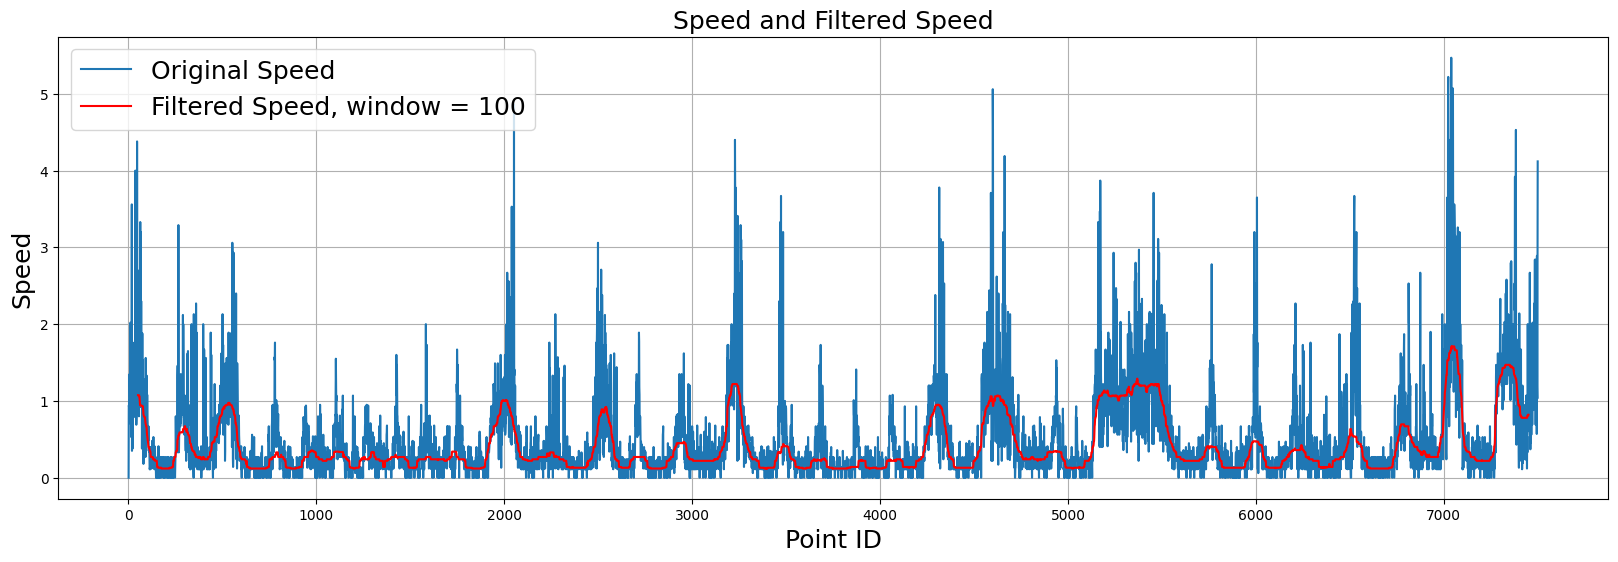

In [ ]:
import matplotlib.pyplot as plt

# Assuming object2.traj_df is already defined and filtered_df is the filtered DataFrame for 'T1_person1'

# Calculate the rolling median and store it in a new column 'den'
window = 100
object2.traj_df["den"] = (
    object2.traj_df.groupby("person_id")["speed"]
    .rolling(window=window, center=True)
    .median()
    .reset_index(level=0, drop=True)
)

# Filter the DataFrame for 'T1_person1' again to include the new 'den' values
filtered_df = object2.traj_df[object2.traj_df['person_id'] == "T1_person1"]

# Plotting
plt.figure(figsize=(20, 6))  # Set the size of the plot

# Plot original speeds
filtered_df.plot(x='n_point_id', y='speed', ax=plt.gca(), legend=True, grid=True, label='Original Speed')

# Plot filtered speeds (den)
filtered_df.plot(x='n_point_id', y='den', ax=plt.gca(), legend=True, grid=True, color='red', label=f'Filtered Speed, window = {window}')

plt.xlabel('Point ID', fontsize=18)  # X-axis label
plt.ylabel('Speed', fontsize=18)  # Y-axis label
plt.title('Speed and Filtered Speed', fontsize=18)  # Title of the plot
plt.grid(True)  # Show grid
# plt.legend(['Speed', f'Filtered Speed, window = {window}'])
plt.legend(fontsize=18)  # Legend
plt.show()


In [ ]:
# @title window length auto. BUT refine first THEN club
import time

alpha = 'auto'  # fetches window sizes at elbow points
window_size = "auto"  # must be set to 'auto' if alpha is 'auto'

tol = 2.00  # extend end points until std * tol
cutoff_duration = 10  # discards segments < cutoff_duration
mode = "median"  # moving window function. ['median', 'mean', 'ewm']

start_time = time.time()

# Pass ground truth df in the constructor if you want to visualise the parts.
# of the speed signal that correspond to the real stops.
# For this functionality, call the method "scipy_peaks_plot()"
# Implementation of this in file VisualiseSegments.py in this repo.

object1 = MovMedSpeedSegmenter(df, exhibits_df)
object1.process_trajectory_data()
object1.elbow_curve(min=1, max=150, step=3, plot=False)

# t1 = object1.elbow_points_df['second_elbow'].mean()

object1.optimal_window_filter(alpha='auto')
seg_df = object1.segment_graph(mode="median", window_size="auto") # -> seg_df
seg_df = object1.refine_end_segment_boundaries(tol, seg_df) # -> fin_seg_df
seg_df = object1.closest_exhibit_from_geom(seg_df)

result_segments = object1.club_segments_df(cutoff_duration, seg_df)

end_time = time.time()

total_time = end_time - start_time
print(f'Execution time: {total_time}')


# Uncomment the following part if you want to test the results with
# ground truth segments. Make sure to pass ground truth stops in the
# constructor. Here, "df_gt".


eval_med = MatchingRetrieverNew(result_segments, df_gt)
eval_med.process_prep()

eval_results = eval_med.find_match(alfa=0.5)

if eval_results is not None:
    print(f"Ends refined with {tol}*std: ",
          eval_results['avg_jacc'].mean(),
          "+-",
          eval_results['avg_jacc'].std()
    )

    print(eval_results[['person_id', 'f_measure', 'avg_jacc']])
    print(eval_results[['f_measure', 'avg_jacc']].mean())
    # print(eval_results[['recall', 'precision', 'accuracy']].mean())

    print(
        eval_results[
            ["true_positive", "true_negative",
             "false_positive", "false_negative"]
        ].sum()
    )

In [ ]:
# @title [OLD] class MovMedSpeedSegmenter

# import logging
# import math
# import pandas as pd, time
# import numpy as np
# import scipy.signal
# from scipy.spatial.distance import cdist
# import geopandas as gpd
# from shapely.geometry import Point, MultiLineString
# from shapely.wkb import loads
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from ipywidgets import HTML, VBox, Layout, HBox, Label, Button, Output, IntText
# from IPython.display import display, clear_output


# class MovMedSpeedSegmenter:
#   DEFAULT_WINDOW_SIZE = 50
#   DEF_DIST = 20  # distance threshold for Scipy find_peaks()
#   DEF_WID = 10  # width threshold for Scipy find_peaks()

#   def __init__(self, df, exhibits_df, df_gt = None):
#     self.logger = self.setup_logging(level=logging.INFO)
#     self.traj_df = df.copy()  # input trajectories dataframe
#     self.exhibits_df = exhibits_df.copy()  # POIs dataframe
#     self.groundtruth_df = df_gt.copy()  #  Groundtruth segments dataframe
#     self.final_segments_df = None  # Output segments dataframe
#     self.segments_df = None  # Output before clubbing and duration cut
#     self.red_peaks_ = None
#     self.blue_peaks_ = None
#     self.red_peaks = None
#     self.red_heights = None
#     self.blue_peaks = None
#     self.blue_heights = None
#     self.window_size = 0

#   @staticmethod
#   def setup_logging(level=logging.INFO):
#       logger = logging.getLogger('MovMedSpeedSegmenter')
#       logger.setLevel(level)

#       if logger.handlers:
#           for handler in logger.handlers:
#               handler.setLevel(level)
#               formatter = logging.Formatter('%(levelname)s - %(message)s')
#               handler.setFormatter(formatter)
#       else:
#           ch = logging.StreamHandler()
#           ch.setLevel(level)
#           formatter = logging.Formatter('%(levelname)s - %(message)s')
#           ch.setFormatter(formatter)
#           logger.addHandler(ch)

#       logger.propagate = False
#       return logger


#   def process_trajectory_data(self) -> pd.DataFrame:
#       """
#       1. Adds features to traj_df: maonly "speed"
#       2. Sorts, converts timestamps to datetime objects.
#       """

#       self.logger.info("Total rows loaded: %d", len(self.traj_df))
#       self.groundtruth_df = self.groundtruth_df.sort_values(
#           by=['person_id', 'start']
#           )
#       self.groundtruth_df['start'] = pd.to_datetime(
#           self.groundtruth_df['start']
#           )
#       self.groundtruth_df['end'] = pd.to_datetime(
#           self.groundtruth_df['end']
#           )

#       self.traj_df['time_stamp'] = pd.to_datetime(self.traj_df['time_stamp'])
#       self.traj_df['label_ground'] = 0

#       for index_gt, row_gt in self.groundtruth_df.iterrows():
#           start_time = pd.to_datetime(row_gt['start'])
#           end_time = pd.to_datetime(row_gt['end'])
#           matching_rows = self.traj_df[
#                           (self.traj_df['time_stamp'] >= start_time) &
#                           (self.traj_df['time_stamp'] <= end_time) &
#                           (self.traj_df['person_id'] == row_gt['person_id'])
#           ]
#           self.traj_df.loc[
#               matching_rows.index, 'label_ground'
#               ] = row_gt['gt_labeling']

#       self.traj_df = self.traj_df.sort_values(by=['person_id', 'time_stamp'])
#       self.traj_df['time_stamp'] = pd.to_datetime(self.traj_df['time_stamp'])
#       self.traj_df['n_point_id'] = self.traj_df.groupby(
#           'person_id'
#           ).cumcount() + 1

#       def _calculate_speed(group):
#         group['duration'] = group[
#             'time_stamp'
#             ].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds()
#         group['distance'] = (
#             ((group['x_kf'].shift(-1) - group['x_kf']) ** 2 +
#               (group['y_kf'].shift(-1) - group['y_kf']) ** 2) ** 0.5
#         ).round(2)
#         group['speed'] = (group['distance'] / group['duration']).round(2)
#         group['speed'] = group['speed'].replace(
#             [float('inf'), -float('inf')], 0
#             )
#         return group
#       self.traj_df = self.traj_df.groupby(
#           'person_id', group_keys=False
#           ).apply(_calculate_speed)

#       # self.traj_df['denoised_speed'] = (
#       #     self.traj_df.groupby('person_id')['speed']
#       #     .rolling(window=50, center=False
#       #     ).median().reset_index(level=0, drop=True)
#       # )
#       return self.traj_df.copy()

#   def segment_graph(self, mode=None, window_size=None) -> pd.DataFrame:
#       """
#       1. Finds peaks and valleys in the moving median graph using
#          Scipy's "find_peaks()":
#          - high speed points (peaks): red_peaks_
#          - low speed points (valleys): blue_peaks_ (by inverting the y-axis)
#       2. Extracts segments: [peak, subsequent valley before next peak]
#       3. Returns the segments_df
#       """
#       def _process_segment(
#               df_group, start_index, end_index, person_id, label, s,
#               valley_start, blu_line, red_line):

#           """Calculates centroids, start, end points, duration of segments."""

#           start_time = df_group.iloc[start_index]['time_stamp']
#           end_time = df_group.iloc[end_index]['time_stamp']
#           start_id = df_group.iloc[start_index]['n_point_id']
#           end_id = df_group.iloc[end_index]['n_point_id']
#           segment_df = df_group.iloc[start_index:end_index + 1]
#           x_centroid = segment_df['x_kf'].mean()
#           y_centroid = segment_df['y_kf'].mean()
#           duration = (end_time - start_time).total_seconds()
#           return [person_id, label, x_centroid, y_centroid,
#                   start_time, end_time, start_id, end_id, duration,
#                   s, valley_start, blu_line, red_line
#                   ]

#       if window_size is None:
#         self.window_size = MovMedSpeedSegmenter.DEFAULT_WINDOW_SIZE
#       else:
#         self.window_size = window_size

#       if mode == "median" or mode is None:
#           self.traj_df['denoised_speed'] = (
#               self.traj_df.groupby('person_id')['speed']
#               .rolling(window=self.window_size, center=False).median()
#               .reset_index(level=0, drop=True)
#           )
#       elif mode == "mean":
#           self.traj_df['denoised_speed'] = (
#               self.traj_df.groupby('person_id')['speed']
#               .rolling(window=self.window_size, center=False).mean()
#               .reset_index(level=0, drop=True)
#           )
#       elif mode == "ema" or mode == "ewm":
#           self.traj_df['denoised_speed'] = (
#               self.traj_df.groupby('person_id', group_keys=True)['speed']
#               .apply(lambda x: x.ewm(span=self.window_size, adjust=True)
#               .mean()
#               ).reset_index(level=0, drop=True)
#           )

#       self.red_peaks_ = self.traj_df.groupby('person_id').apply(
#           lambda x: scipy.signal.find_peaks(
#               x['denoised_speed'],
#               height=x['denoised_speed'].median(),
#               distance=MovMedSpeedSegmenter.DEF_DIST,
#               width=MovMedSpeedSegmenter.DEF_WID,
#           )
#       )

#       self.red_peaks = self.red_peaks_.apply(lambda x: x[0])
#       self.red_heights = self.red_peaks_.apply(lambda x: x[1])
#       self.blue_peaks_ = self.traj_df.groupby('person_id').apply(
#           lambda x: scipy.signal.find_peaks(
#               -x['denoised_speed'],
#               height=-np.median(self.red_heights[x.name]['peak_heights']),
#               distance=MovMedSpeedSegmenter.DEF_DIST,
#               width=MovMedSpeedSegmenter.DEF_WID
#               )
#       )
#       self.blue_peaks = self.blue_peaks_.apply(lambda x: x[0])
#       self.blue_heights = self.blue_peaks_.apply(lambda x: x[1])

#       # Extraction of segments
#       segments = []
#       for person_id, df_group in self.traj_df.groupby('person_id'):
#           red_indices = self.red_peaks[person_id]
#           blue_indices = self.blue_peaks[person_id]
#           label = 1
#           start_index = end_index = None
#           blu_line = red_line = None
#           valley_start = None
#           s = 0.0
#           first_point_id = df_group['n_point_id'].iloc[0]
#           for i, row in enumerate(df_group.itertuples()):
#               if i == first_point_id:
#                   start_index = i
#               if row.n_point_id in red_indices and start_index is None:
#                   # Peak, start of a new segment
#                   start_index = i
#               elif row.n_point_id in blue_indices and start_index is not None:
#                   # Valley after peak, possible end of the current segment
#                   if valley_start is None:
#                     valley_start = i
#                   end_index = i
#               elif row.n_point_id in red_indices and start_index is not None:
#                   if end_index is not None:
#                       # Next peak found
#                       # Finalize the segment
#                       blu_line = np.median(
#                           self.red_heights[person_id]['peak_heights']
#                           )
#                       red_line = np.median(row.denoised_speed)
#                       s = df_group.iloc[
#                           start_index:end_index
#                           ]['denoised_speed'].std()

#                       segments.append(
#                           _process_segment(
#                               df_group, start_index, end_index, person_id,
#                               label, s, valley_start, blu_line, red_line
#                           )
#                       )
#                       label += 1
#                       start_index = i
#                       end_index = None
#                       valley_start = None
#                   else:
#                       # Peak right after another peak, no valley
#                       # Restart segment from present peak
#                       start_index = i
#                       end_index = None
#           if start_index is not None and end_index is not None:
#               segments.append(
#                   _process_segment(
#                       df_group, start_index, end_index, person_id,
#                       label, s, valley_start, blu_line, red_line
#                   )
#               )
#       self.segments_df = pd.DataFrame(
#           segments,
#           columns=[
#               'person_id', 'label', 'x_centroid', 'y_centroid',
#               'start_time', 'end_time', 'start_id', 'end_id',
#               'duration', 's', 'valley_start', 'blu_line', 'red_line'
#           ]
#       )

#       self.logger.info(
#           f"Number of raw segments before clubbing: {len(self.segments_df)}; "
#           f"window size = {self.window_size}"
#       )
#       return self.segments_df.copy()

#   def closest_exhibit_from_point(self):
#       """
#       Finds closest exhibit to each segment's centriod.
#       For exhibit type: point coordinates.
#       Returns the segments_df with closest exhibit and the distance to it.
#       """

#       self.segments_df = self.segments_df.sort_values(
#           by=['person_id', 'label']
#           )
#       segments_array = self.segments_df[
#           ['x_centroid', 'y_centroid']
#           ].to_numpy()
#       pois_array = self.exhibits_df[['x', 'y']].to_numpy()
#       distances = cdist(segments_array, pois_array)
#       closest_indices = distances.argmin(axis=1)
#       self.segments_df['exhibit_o'] = (
#           self.exhibits_df.iloc[closest_indices]['name'].values
#       )
#       self.segments_df['exh_dist'] = distances.min(axis=1)
#       return self.segments_df

#   def closest_exhibit_from_geom(self) -> pd.DataFrame:
#       """
#       Finds closest exhibit to each segment's centroid.
#       For exhibit type: geometric objects.
#       Returns the segments_df with closest exhibit and the distance to it.
#       """

#       self.segments_df = self.segments_df.sort_values(
#           by=['person_id', 'label']
#           )
#       def _find_POI(row):
#           point = Point(row['x_centroid'], row['y_centroid'])
#           closest_exhibit = min(
#               self.exhibits_df.itertuples(),
#               key=lambda exhibit: point.distance(loads(exhibit.geom, hex=True))
#           )

#           distance = point.distance(loads(closest_exhibit.geom, hex=True))
#           return pd.Series(
#               [closest_exhibit.name, distance],
#               index=['exhibit_o', 'exh_dist']
#           )


#       result_df = self.segments_df.apply(_find_POI, axis=1)
#       self.segments_df[['exhibit_o', 'exh_dist']] = result_df
#       return self.segments_df

#   def club_segments_df(self, cutoff_duration=None) -> pd.DataFrame:
#       """
#       1. Clubs consecutive segments with same exhibit in proximity
#       2. Optional: discards segments that have duration < cutoff_duration
#       3. Recalculates centroids, updates start, end points and duration
#          of segments.
#       4. Returns the final_segments_df.
#       """
#       def _calculate_centroids(row):
#           points_in_segment = self.traj_df[
#               (self.traj_df['person_id'] == row['person_id']) &
#               (self.traj_df['n_point_id'] >= row['start_id']) &
#               (self.traj_df['n_point_id'] <= row['end_id'])
#           ]
#           return pd.Series({
#               'x_centroid': points_in_segment['x_kf'].mean(),
#               'y_centroid': points_in_segment['y_kf'].mean()
#           })

#       def _calculate_std(row):
#         relevant_data = self.traj_df[
#             (self.traj_df['person_id'] == row['person_id'])
#             & (self.traj_df['n_point_id'] >= row['valley_start'])
#             & (self.traj_df['n_point_id'] <= row['end_id'])
#         ]
#         if len(relevant_data) >= 2:
#             return relevant_data['denoised_speed'].std()
#         else:
#             return np.nan

#       self.final_segments_df = (
#           self.segments_df.merge(
#               self.traj_df,
#               left_on=['person_id', 'start_id'],
#               right_on=['person_id', 'n_point_id']
#           )
#           .groupby([
#               'person_id',
#               'exhibit_o',
#               (
#                   self.segments_df['exhibit_o'] !=
#                   self.segments_df['exhibit_o'].shift()
#               ).cumsum()
#           ])
#           .agg(
#               person_id=('person_id', 'first'),
#               exhibit_o=('exhibit_o', 'first'),
#               start_time=('start_time', 'first'),
#               end_time=('end_time', 'last'),
#               start_id=('start_id', 'first'),
#               end_id=('end_id', 'last'),
#               exh_dist=('exh_dist', 'mean'),
#               s=('s', 'first'),
#               valley_start=('valley_start', 'first'),
#               blu_line=('blu_line', 'first'),
#               red_line=('red_line', 'first'),
#           )
#           .reset_index(level=[0, 1], drop=True)
#           .reset_index(drop=True)
#       )
#       self.final_segments_df = self.final_segments_df.sort_values(
#           by=['person_id', 'start_id']
#           )

#       self.final_segments_df[
#           ['x_centroid', 'y_centroid']
#           ] = self.final_segments_df.apply(_calculate_centroids, axis=1)

#       self.final_segments_df['s'] = self.final_segments_df.apply(
#          _calculate_std, axis=1
#           )

#       self.final_segments_df = self.final_segments_df.assign(
#           label=lambda x: x.groupby('person_id').cumcount() + 1,
#           start_time=lambda x: pd.to_datetime(x['start_time']),
#           end_time=lambda x: pd.to_datetime(x['end_time']),
#           duration=lambda x: (
#               x['end_time'] - x['start_time']
#               ).dt.total_seconds()
#       )

#       if cutoff_duration is not None and cutoff_duration != 0:
#           self.final_segments_df = self.final_segments_df[
#               self.final_segments_df['duration'] >= cutoff_duration
#               ]
#           self.logger.info("Cut-off duration set: %d", cutoff_duration)
#       else:
#           self.logger.info("No cut_off duration set")
#       self.logger.info(
#           "Final segments after clubbing: %d", len(self.final_segments_df)
#           )
#       self.final_segments_df = self.final_segments_df.sort_values(
#           by=['person_id', 'start_id']
#           )
#       self.final_segments_df = self.final_segments_df.assign(
#           label=lambda x: x.groupby('person_id').cumcount() + 1,
#       )

#       return self.final_segments_df.copy()

#   def export_segments_csv(self, path=None):
#     if self.final_segments_df is None:
#       self.logger.info("Finid the segments first!")
#     if path is not None:
#       self.final_segments_df.to_csv(path, index=True)
#       self.logger.info(f"Exported to {path}!")
#     else:
#       self.final_segments_df.to_csv('/content/final_segments.csv', index=True)
#       self.logger.info("Exported to /content/final_segments.csv!")

#   def scipy_peaks_plot(self):

#       """
#       1. Choose parameters looking at the graph per eaach user.
#       2. Overlay extracted segments on the graph
#       3. Set duration cut-off and export to .csv file

#       """
#       segments_found = False
#       median_seg = False
#       unique_person_ids = self.traj_df['person_id'].unique().tolist()
#       dropdown = widgets.Dropdown(
#           options=unique_person_ids,
#           value=unique_person_ids[0] if unique_person_ids else None,
#           description='Person ID:',
#       )
#       dropdown.layout = Layout(margin='15px 0 15px 0')
#       window_size_slider = widgets.IntSlider(value=20, min=1, max=200, step=5,
#                                              description='Window Size:',
#                                              layout=widgets.Layout(width='50%')
#                                              )
#       height_slider = widgets.FloatSlider(value=-0.8, min=-1.2, max=1.0,
#                                           step=0.1, description='Height:',
#                                           layout=widgets.Layout(width='40%')
#                                           )
#       prom_slider = widgets.FloatSlider(value=None, min=-2.0, max=2.0,
#                                         step=0.01, description='Prominence:',
#                                         layout=widgets.Layout(width='40%')
#                                         )
#       dist_slider = widgets.IntSlider(value=1, min=1, max=200, step=1,
#                                       description='Distance:',
#                                       layout=widgets.Layout(width='40%')
#                                       )
#       wid_slider = widgets.IntSlider(value=10, min=1, max=100, step=1,
#                                      description='Width:',
#                                      layout=widgets.Layout(width='40%')
#                                      )
#       height_slider1 = widgets.FloatSlider(value=0.3, min=-1.2, max=1.0,
#                                            step=0.1, description='Height1:',
#                                            layout=widgets.Layout(width='40%')
#                                            )
#       prom_slider1 = widgets.FloatSlider(value=None, min=-2.0, max=2.0,
#                                          step=0.01, description='Prominence1:',
#                                          layout=widgets.Layout(width='40%')
#                                          )
#       dist_slider1 = widgets.IntSlider(value=20, min=1, max=200, step=1,
#                                        description='Distance1:',
#                                        layout=widgets.Layout(width='40%')
#                                        )
#       wid_slider1 = widgets.IntSlider(value=20, min=1, max=100, step=1,
#                                       description='Width1:',
#                                       layout=widgets.Layout(width='40%')
#                                       )

#       # btn_find_segments = Button(description='Find Segments')
#       btn_export_csv = Button(description='Export to CSV')
#       btn_find_segments_med = Button(description='Find Segments (medians)')

#       plot_output = Output()
#       output = Output()

#       duration_text = IntText(
#             value=5,
#             description='Duration:',
#             disabled=False,
#             style={'description_width': 'initial'}
#       )
#       def _label_do():
#           self.traj_df['label_estim'] = 0
#           for _, segment in self.final_segments_df.iterrows():

#             segment_range1 = ((self.traj_df['person_id'] == segment['person_id'])
#                               & (self.traj_df['n_point_id'] >= segment['start_id'])
#                               & (self.traj_df['n_point_id'] <= segment['end_id'])
#                             )
#             self.traj_df.loc[segment_range1, 'label_estim'] = segment['label']

#       def _on_export_csv_click(_):
#         if self.final_segments_df is None:
#           self.logger.info("Find the segments first!")
#         else:
#           self.export_segments_csv()

#       def _on_find_segments_median_click(_):
#           nonlocal segments_found
#           nonlocal median_seg
#           with output:
#               clear_output()
#               self.logger.info("Finding segments")
#               segments_found = True
#               duration = max(0, duration_text.value)
#               window_size = window_size_slider.value
#               self.segment_graph('median',window_size)
#               self.closest_exhibit_from_geom()
#               self.club_segments_df(duration)
#               # self.refine_end_segment_boundaries(0.05)
#               # self.refine_start_segment_boundaries(2.1)
#               _label_do()
#               median_seg = True
#               _update_plot()

#       def _update_plot(change=None):
#         nonlocal segments_found
#         nonlocal median_seg
#         with plot_output:
#           plot_output.clear_output()
#           selected_person_id = dropdown.value
#           window_size = window_size_slider.value
#           h = height_slider.value
#           prom = prom_slider.value
#           dist = dist_slider.value
#           wid = wid_slider.value
#           h1 = height_slider1.value
#           p1 = prom_slider1.value
#           d1 = dist_slider1.value
#           w1 = wid_slider1.value



#           fig, ax = plt.subplots(figsize=(30, 5))
#           fig1, ax1 = plt.subplots(figsize=(30, 5))

#           if median_seg is False:
#             self.traj_df['denoised_speed'] = (
#                 self.traj_df.groupby('person_id')['speed']
#                 .rolling(window=window_size, center=False)
#                 .median().reset_index(level=0, drop=True)
#             )

#             selected_df = self.traj_df[
#                 self.traj_df['person_id'] == selected_person_id
#                 ]

#             x = selected_df['n_point_id']
#             y = selected_df['denoised_speed']
#             ax.plot(x, y, label='movMed_speed', color='green')
#             ax1.plot(x, y, label='movMed_speed', color='green')

#             mask1 = selected_df['label_ground'] != 0
#             y2 = np.where(mask1, y, np.nan)
#             ax1.plot(x, y2, label='Detected segments', c='red')
#             peaks1 = scipy.signal.find_peaks(-y, height=h, distance=dist,
#                                             prominence=prom, width=wid)
#             peak_pos1 = peaks1[0]
#             heights1 = peaks1[1]['peak_heights']

#             peaks2 = scipy.signal.find_peaks(y, height=h1)
#             peak_pos2 = peaks2[0]
#             heights2 = peaks2[1]['peak_heights']
#             ax.scatter(peak_pos1, -heights1, color='blue', s=30,
#                       marker='x', label='Valleys')
#             ax.scatter(peak_pos2, heights2, color='red', s=30,
#                         marker='o', label='Peaks')

#             if segments_found:
#               mask = selected_df['label'] != 0
#               y1 = np.where(mask, y, np.nan)
#               ax.plot(x, y1, label='Detected segments', c='#ffbe0b')

#           else:
#             self.traj_df['denoised_speed'] = (
#                 self.traj_df.groupby('person_id')['speed']
#                 .rolling(window=window_size, center=False)
#                 .median().reset_index(level=0, drop=True)
#             )
#             selected_df = self.traj_df[
#                 self.traj_df['person_id'] == selected_person_id
#                 ]
#             x = selected_df['n_point_id']
#             y = selected_df['denoised_speed']
#             ax.plot(x, y, label='movMed_speed', color='green')
#             ax1.plot(x, y, label='movMed_speed', color='green')
#             mask1 = selected_df['label_ground'] != 0
#             y2 = np.where(mask1, y, np.nan)
#             ax1.plot(x, y2, label='Detected segments', c='red')

#             self.red_peaks_ = self.traj_df.groupby('person_id').apply(
#                 lambda x: scipy.signal.find_peaks(
#                     x['denoised_speed'],
#                     height=x['denoised_speed'].median(),
#                     distance=20, width=10
#                 )
#             )
#             self.red_peaks = self.red_peaks_.apply(lambda x: x[0])
#             self.red_heights = self.red_peaks_.apply(lambda x: x[1])

#             self.blue_peaks_ = self.traj_df.groupby('person_id').apply(
#                 lambda x: scipy.signal.find_peaks(
#                     -x['denoised_speed'],
#                     height=-np.median(
#                         self.red_heights[x.name]['peak_heights']
#                         ),
#                     distance=20, width=20
#                 )
#             )

#             self.blue_peaks = self.blue_peaks_.apply(lambda x: x[0])
#             self.blue_heights = self.blue_peaks_.apply(lambda x: x[1])
#             peak_pos_blue = self.blue_peaks[selected_person_id]
#             heights_blue = (
#                 self.blue_heights[selected_person_id]['peak_heights']
#             )

#             peak_pos_red = self.red_peaks[selected_person_id]
#             heights_red = self.red_heights[selected_person_id]['peak_heights']

#             ax.scatter(peak_pos_blue, -heights_blue, color='blue', s=30,
#                       marker='x', label='Valleys')
#             ax.scatter(peak_pos_red, heights_red, color='red', s=30,
#                         marker='o', label='Peaks')
#             if segments_found:
#               mask = selected_df['label_estim'] != 0
#               y1 = np.where(mask, selected_df['denoised_speed'], np.nan)
#               ax.plot(x, y1, label='Detected segments', c='#ffbe0b')

#               if self.red_heights is not None and not self.red_heights.empty:
#                 blue_line_y = (
#                     np.median(self.red_heights[
#                         selected_df['person_id'].iloc[0]]['peak_heights'
#                         ]
#                     )
#                 )
#                 red_line_y = selected_df['denoised_speed'].median()
#               else:
#                 blue_line_y = 0
#                 red_line_y = 0

#               ax.axhline(y=blue_line_y, color='blue', linewidth=1.3,
#                          label='Valleys threshold')
#               ax.axhline(y=red_line_y, color='red', linewidth=1.3,
#                          label='Peaks threshold')



#           ax.set_xlabel('point_id')
#           ax.set_ylabel('MovMed_speed')
#           ax.set_title(
#               f'Moving median of speed. User: "{selected_person_id}" '
#               f'Window Size: "{window_size}"'
#           )
#           ax.legend()

#           ax.grid(True, which='both', linestyle='--', linewidth=1)
#           ax.set_xticks(np.arange(min(x), max(x)+1, 150))
#           ax1.grid(True, which='both', linestyle='--', linewidth=1)
#           ax1.set_xticks(np.arange(min(x), max(x)+1, 150))
#           plt.show()


#       duration_text.layout = Layout(margin='15px 0 15px 0')
#       fndseg_layout = Layout(margin='15px 0 15px 0')
#       btn_export_csv.layout = Layout(margin='5px 0 30px 0')
#       btn_find_segments_med.layout = Layout(margin='5px 0 15px 0')
#       btn_export_csv.on_click(_on_export_csv_click)
#       btn_find_segments_med.on_click(_on_find_segments_median_click)
#       # btn_find_segments.observe(_update_plot, names='value')  # type: ignore
#       dropdown.observe(_update_plot, names='value') # type: ignore
#       window_size_slider.observe(_update_plot, names='value') # type: ignore
#       height_slider.observe(_update_plot, names='value') # type: ignore
#       prom_slider.observe(_update_plot, names='value') # type: ignore
#       dist_slider.observe(_update_plot, names='value') # type: ignore
#       wid_slider.observe(_update_plot, names='value') # type: ignore
#       height_slider1.observe(_update_plot, names='value') # type: ignore
#       prom_slider1.observe(_update_plot, names='value') # type: ignore
#       dist_slider1.observe(_update_plot, names='value') # type: ignore
#       wid_slider1.observe(_update_plot, names='value') # type: ignore
#       heading1 = HTML(
#           value="<h3 style='font-size:20px; font-weight:bold; color:red;'>" +
#             "Adjust Peaks:</h3>"
#           )
#       heading2 = HTML(
#           value="<h3 style='font-size:20px; font-weight:bold; color:#54c5e0;'>" +
#             "Adjust Valleys:</h3>"
#           )

#       blue_peaks_box = VBox([height_slider, prom_slider,
#                              dist_slider, wid_slider])
#       red_peaks_box = VBox([height_slider1, prom_slider1,
#                             dist_slider1, wid_slider1])
#       # display(VBox([heading1, red_peaks_box, heading2, blue_peaks_box,
#       #               dropdown, window_size_slider, duration_text,
#       #               btn_find_segments_med, output, btn_export_csv,
#       #               plot_output])
#       # )
#       display(VBox([dropdown, window_size_slider, duration_text,
#                     btn_find_segments_med, output, plot_output])
#       )
#       _update_plot(None)

#   def refine_end_segment_boundaries(
#       self, tolerance, fin_seg_df=None) -> pd.DataFrame:

#     if fin_seg_df is not None:
#         self.final_segments_df = fin_seg_df.copy()
#     self.final_segments_df['next_start_id'] = (
#         self.final_segments_df['start_id'].shift(-1)
#         .fillna(method='ffill').astype(int)
#     )

#     for index, row in self.final_segments_df.iterrows():
#         if row['valley_start'] == row['end_id']:
#             continue
#         person_id = row['person_id']
#         traj_data = self.traj_df[self.traj_df['person_id'] == person_id]
#         for i in range(row['end_id'], row['next_start_id']):
#             current_speed = traj_data.loc[
#                 traj_data['n_point_id'] == i, 'denoised_speed'
#                 ].iloc[0]
#             end_speed = traj_data.loc[
#                 traj_data['n_point_id'] == row['end_id'],
#                 'denoised_speed'
#                 ].iloc[0]
#             if current_speed > end_speed + (row['s']*tolerance):
#                 time = traj_data.loc[
#                     traj_data['n_point_id'] == i, 'time_stamp'
#                     ].iloc[0]
#                 self.final_segments_df.at[index, 'end_id'] = i
#                 self.final_segments_df.at[index, 'end_time'] = time
#                 break
#     self.logger.info("Ends adjusted.")
#     return self.final_segments_df.copy()

#   def refine_start_segment_boundaries(
#       self, tolerance, fin_seg_df=None) -> pd.DataFrame:

#     if fin_seg_df is not None:
#         self.final_segments_df = fin_seg_df.copy()
#     self.final_segments_df['next_start_id'] = (
#         self.final_segments_df['start_id'].shift(-1)
#         .fillna(method='ffill').astype(int)
#     )

#     for index, row in self.final_segments_df.iterrows():
#         if row['valley_start'] == row['end_id']:
#             continue
#         person_id = row['person_id']
#         traj_data = self.traj_df[self.traj_df['person_id'] == person_id]
#         blu = np.median(
#             self.red_heights[traj_data['person_id'].iloc[0]]['peak_heights']
#             )
#         for i in range(row['start_id'], row['valley_start']):
#             current_speed = traj_data.loc[
#                 traj_data['n_point_id'] == i, 'denoised_speed'
#                 ].iloc[0]
#             valley_speed = traj_data.loc[
#                 traj_data['n_point_id'] == row['valley_start'],
#                 'denoised_speed'
#                 ].iloc[0]
#             if current_speed > blu:
#               if current_speed < valley_speed + row['s']*tolerance:
#                 time = traj_data.loc[
#                     traj_data['n_point_id'] == i, 'time_stamp'
#                     ].iloc[0]
#                 self.final_segments_df.at[index, 'start_id'] = i
#                 self.final_segments_df.at[index, 'start_time'] = time
#                 break
#     self.logger.info("Starts adjusted.")
#     return self.final_segments_df.copy()

In [ ]:
# @title MatRetrNew  NEW EVAL

from pulp import *
import os
import psycopg2
import numpy as np
import pandas as pd
import math

DURATION = 10.0
MatchingRetrieverNew.J_LIMIT = 0.0
ALFA = 0.5
self.beta = 1 - ALFA
JUST_FOR_PRINT = False
np.set_printoptions(threshold=sys.maxsize)


class MatchingRetrieverNew1(object):
    def __init__(self, cl_df, gt_df):
        self.cl_df = cl_df.copy()
        self.gt_df = gt_df.copy()
        self.gt_lists = None
        self.cl_lists = None
        self.results_df = None

    def process_prep(self):

        self.cl_df.sort_values(by=["person_id", "label"], inplace=True)
        self.gt_df.sort_values(by=["person_id", "gt_labeling"], inplace=True)

        self.cl_df["start_time"] = pd.to_datetime(self.cl_df["start_time"])
        self.cl_df["end_time"] = pd.to_datetime(self.cl_df["end_time"])
        self.gt_df["start"] = pd.to_datetime(self.gt_df["start"])
        self.gt_df["end"] = pd.to_datetime(self.gt_df["end"])

        self.cl_df["start_time_seconds"] = self.cl_df["start_time"].apply(
            lambda x: x.timestamp()
        )
        self.cl_df["end_time_seconds"] = self.cl_df["end_time"].apply(
            lambda x: x.timestamp()
        )

        self.gt_df["start_time_seconds"] = self.gt_df["start"].apply(
            lambda x: x.timestamp()
        )
        self.gt_df["end_time_seconds"] = self.gt_df["end"].apply(
            lambda x: x.timestamp()
        )

        self.gt_lists = []
        for person_id in self.gt_df["person_id"].unique():
            filtered_df = self.gt_df[self.gt_df["person_id"] == person_id]
            current_list = filtered_df.apply(
                lambda row: [
                    row["gt_labeling"],
                    row["start_time_seconds"],
                    row["end_time_seconds"],
                    round((row["end_time_seconds"]
                         - row["start_time_seconds"]), 3),
                    (row["x_centroid"],
                    row["y_centroid"]),
                    row["person_id"],
                    row["gt_poi"],
                ],
                axis=1,
            ).tolist()
            self.gt_lists.append(current_list)

        self.cl_lists = []

        for person_id in self.cl_df["person_id"].unique():
            filtered_df = self.cl_df[self.cl_df["person_id"] == person_id]
            current_list = filtered_df.apply(
                lambda row: [
                    row["label"],
                    row["start_time_seconds"],
                    row["end_time_seconds"],
                    round((
                        row["end_time_seconds"]
                      - row["start_time_seconds"]), 3),
                    (row["x_centroid"],
                    row["y_centroid"]),
                    row["person_id"],
                    row["exhibit_o"],
                ],
                axis=1,
            ).tolist()
            self.cl_lists.append(current_list)

    def find_match(self):
        results_list = []
        for gt, cl in zip(self.gt_lists, self.cl_lists):
            self.long_stops_count = 0
            self.short_stops_count = 0
            long_gt = []
            short_gt = []
            for g in gt:
                if g[3] >= DURATION:
                    self.long_stops_count += 1
                    long_gt.append(g)
                else:
                    self.short_stops_count += 1
                    short_gt.append(g)

            gt = long_gt

            all_stops = [
                ("S"
                 + str(item[0]), item[1], item[2], item[3], item[4], item[5])
                for item in gt
            ]
            all_clusters = [
                (str(item[0]), item[1], item[2], item[3], item[4], item[5])
                for item in cl
            ]
            length = max(len(gt), len(cl))

            if len(gt) < len(cl):
                diff = len(cl) - len(gt)
                for i in range(diff):
                    all_stops.append(
                        ("SNULL", -1, -1, -1, ("NULL", "NULL"), -1)
                        )
            elif len(cl) < len(gt):
                diff = len(gt) - len(cl)
                for i in range(diff):
                    all_clusters.append(
                        ("CNULL", -1, -1, -1, ("NULL", "NULL"), -1)
                        )

            intersection_doublearray = []

            stops_set = set()
            clusters_set = set()
            max_dist = 0.0

            for s in all_stops:
                l = []
                for c in all_clusters:
                    if (s[1] <= c[1] and c[1] <= s[2]) or (
                        c[1] <= s[1] and s[1] <= c[2]
                    ):
                        if s[5] == c[5]:
                            intersection = min(c[2], s[2]) - max(c[1], s[1])
                            union = max(c[2], s[2]) - min(c[1], s[1])
                            j = float(intersection) / float(union)

                            if (
                                j * 100 > MatchingRetrieverNew.J_LIMIT
                            ):
                                dist = math.dist(s[4], c[4])
                                if ALFA == 0:
                                    l.append((j, dist))
                                elif ALFA == 1:
                                    l.append((j, dist))
                                else:
                                    l.append((j, dist))

                                stops_set.add(s[0])
                                clusters_set.add(c[0])

                            else:
                                l.append((0, 0))
                        else:
                            l.append((0, 0))
                    else:
                        l.append((0, 0))
                intersection_doublearray.append(l)

            l_alfa = []
            for row in intersection_doublearray:
                l_alfa_row = []
                for ts in row:
                    if ts[0] > 0:
                        l_alfa_row.append(ALFA*ts[0] + self.beta*(1/(1+ts[1])))
                    else:
                        l_alfa_row.append(0.0)
                l_alfa.append(l_alfa_row)

            intersection_matrix = np.array(l_alfa)

            # print(intersection_matrix)
            clusters = list(clusters_set)
            clusters.sort()
            stops = list(stops_set)
            stops.sort()

            prob = LpProblem("Matching_stops", LpMaximize)
            y = LpVariable.dicts(
                "pair",
                [(i, j) for i in range(length) for j in range(length)],
                cat="Binary",
            )
            prob += lpSum(
                [
                    (intersection_matrix[i][j]) * y[(i, j)]
                    for i in range(length)
                    for j in range(length)
                ]
            )

            for i in range(length):
                prob += lpSum(y[(i, j)] for j in range(length)) <= 1
                prob += lpSum(y[(j, i)] for j in range(length)) <= 1
                prob += lpSum(y[(i, j)] + y[(j, i)] for j in range(length)) == 2
            prob += (
                lpSum(y[(i, j)]
                for i in range(length)
                for j in range(length)) == length
            )

            prob.solve()

            average_j = 0.0
            true_positive = 0
            false_negative = 0
            false_positive = 0
            true_negative = 0
            intersection_short = 0
            matched_avgs = []
            sum_avg = 0.0

            true_clusters = []
            true_detected_stops = []

            for i in range(length):
                for j in range(length):
                    if y[(i, j)].varValue == 1:
                        if intersection_matrix[i, j] > 0:
                            if all_stops[i][3] >= DURATION:
                                average_j += intersection_matrix[i, j]
                                true_positive += 1
                                true_clusters.append(all_clusters[j])
                                true_detected_stops.append(all_stops[i])
                                intersection = min(
                                    all_clusters[j][2], all_stops[i][2]
                                ) - max(all_clusters[j][1], all_stops[i][1]
                                )
                                union = max(all_clusters[j][2], all_stops[i][2]
                                )- min(all_clusters[j][1], all_stops[i][1]
                                )
                                jacc = float(intersection) / float(union)
                                matched_avgs.append(
                                    (all_stops[i], all_clusters[j], jacc)
                                )
                                sum_avg += jacc

                            elif all_stops[i][3] > 0:
                                intersection_short += 1

            true_negative = self.short_stops_count - intersection_short
            false_positive = len(cl) - true_positive
            false_negative = self.long_stops_count - true_positive

            if true_positive > 0:
                avg_jacc = sum_avg / len(matched_avgs)
                average_j = average_j / (100 * true_positive)

                recall = true_positive / (true_positive + false_negative)
                precision = true_positive / (true_positive + false_positive)
                f_measure = 2 * recall * precision / (recall + precision)
                # print(f_measure)

            else:
                avg_jacc = 0
                average_j = 0
                recall = 0
                precision = 0
                f_measure = 0
            # print(f_measure)

            accuracy = float(true_positive + true_negative) / float(
                true_positive + true_negative + false_positive + false_negative
            )

            new_row = {
                "accuracy": accuracy,
                "true_positive": true_positive,
                "true_negative": true_negative,
                "false_positive": false_positive,
                "false_negative": false_negative,
                "f_measure": f_measure,
                "recall": recall,
                "precision": precision,
                "avg_jacc": average_j * 100,
                "person_id": gt[0][-2],
            }

            results_list.append(new_row)
        self.results_df = pd.DataFrame(results_list)

In [ ]:
# @title [OLD] MatRetrNew  NEW EVAL

# from pulp import *
# import os
# import psycopg2
# import numpy as np
# import pandas as pd
# import math
# # from scipy.signal import find_peaks

# # GT_VISITS_TABLE= '"gt_visits_before_merge_10sec_mod_9_8_andspace"'
# # PERSON_ID = "'80'"
# # SEQSCAN_visitS_TABLE='"seqscan_test_visit_9_8_alfa_poi"'
# # RESULTS_MATCHING_TABLE='"results_visits_test_9_8_space_alfa_poi"'
# # EPSILON = "15"
# # N = "24"
# # TYPE = "'KF'"
# # METHOD= "'SEQSCAN'"
# # FREQ= "12"
# # GIRO="2"
# # PRESENCE= "10"


# #Database connection
# # USER=""
# # PASS=""
# # HOST=""
# # PORT=""
# # DATABASE="ExpDec_alfa"

# DURATION= 10.0
# J_LIMIT = 0.0

# ALFA=0.5
# BETA=1-ALFA

# JUST_FOR_PRINT=False
# # POI_DISTANCE_THR=2
# np.set_printoptions(threshold=sys.maxsize)


# class MatchingRetrieverNew(object):

#       def __init__(self, cl_df, gt_df):
#         self.cl_df = cl_df.copy()
#         self.gt_df = gt_df.copy()
#         self.gt_lists = None
#         self.cl_lists = None
#         self.results_df = None


#       def process_prep(self):

#         self.cl_df.sort_values(by=['person_id', 'label'], inplace=True)
#         self.gt_df.sort_values(by=['person_id', 'gt_labeling'], inplace=True)

#         self.cl_df['start_time'] = pd.to_datetime(self.cl_df['start_time'])
#         self.cl_df['end_time'] = pd.to_datetime(self.cl_df['end_time'])
#         self.gt_df['start'] = pd.to_datetime(self.gt_df['start'])
#         self.gt_df['end'] = pd.to_datetime(self.gt_df['end'])

#         self.cl_df['start_time_seconds'] = self.cl_df['start_time'].apply(lambda x: x.timestamp())
#         self.cl_df['end_time_seconds'] = self.cl_df['end_time'].apply(lambda x: x.timestamp())

#         self.gt_df['start_time_seconds'] = self.gt_df['start'].apply(lambda x: x.timestamp())
#         self.gt_df['end_time_seconds'] = self.gt_df['end'].apply(lambda x: x.timestamp())

#         self.gt_lists = []
#         for person_id in self.gt_df['person_id'].unique():
#             filtered_df = self.gt_df[self.gt_df['person_id'] == person_id]
#             current_list = filtered_df.apply(
#                 lambda row: [row['gt_labeling'], row['start_time_seconds'], row['end_time_seconds'],
#                              round((row['end_time_seconds'] - row['start_time_seconds']), 3),
#                               (row['x_centroid'], row['y_centroid']), row['person_id'], row['gt_poi']],
#                 axis=1
#             ).tolist()
#             self.gt_lists.append(current_list)

#         self.cl_lists = []

#         for person_id in self.cl_df['person_id'].unique():
#             filtered_df = self.cl_df[self.cl_df['person_id'] == person_id]
#             current_list = filtered_df.apply(
#                 lambda row: [row['label'], row['start_time_seconds'],row['end_time_seconds'],
#                              round((row['end_time_seconds'] - row['start_time_seconds']), 3),
#                               (row['x_centroid'], row['y_centroid']), row['person_id'], row['exhibit_o']],
#                 axis=1
#             ).tolist()
#             self.cl_lists.append(current_list)

#       def find_match(self):
#         results_list = []
#         for gt, cl in zip(self.gt_lists, self.cl_lists):
#           self.long_stops_count = 0
#           self.short_stops_count = 0
#           long_gt = []
#           short_gt = []
#           for g in gt:
#             if g[3]>=DURATION:
#               self.long_stops_count += 1
#               long_gt.append(g)
#             else:
#               self.short_stops_count +=1
#               short_gt.append(g)

#           gt = long_gt


#           all_stops=[("S"+str(item[0]),item[1], item[2], item[3], item[4], item[5]) for item in gt]
#           all_clusters=[(str(item[0]),item[1], item[2], item[3], item[4], item[5]) for item in cl]
#           length=max(len(gt),len(cl))

#           if len(gt)<len(cl):
#             diff=len(cl)-len(gt)
#             for i in range(diff):
#               all_stops.append(("SNULL",-1,-1, -1, ("NULL", "NULL"), -1))
#           elif len(cl)<len(gt):
#             diff=len(gt)-len(cl)
#             for i in range(diff):
#               all_clusters.append(("CNULL",-1,-1, -1, ("NULL", "NULL"), -1))

#           intersection_doublearray=[]

#           stops_set=set()
#           clusters_set=set()
#           max_dist = 0.0

#           for s in all_stops:
#               l = []
#               for c in all_clusters:
#                   if (s[1] <= c[1] and c[1] <= s[2]) or (c[1] <= s[1] and s[1] <= c[2]):
#                       if s[5] == c[5]:
#                           intersection = min(c[2], s[2]) - max(c[1], s[1])
#                           union = max(c[2], s[2]) - min(c[1], s[1])
#                           j = float(intersection) / float(union)

#                           if j * 100 > J_LIMIT:  # SUD: J_LIMIT is zero, this condition now is always true, added once for experimental purposes
#                               dist = math.dist(s[4], c[4])
#                               if ALFA == 0:
#                                   l.append((j, dist))
#                               elif ALFA == 1:
#                                   # l.append((int(j * 100), dist))
#                                   l.append((j, dist))
#                               else:
#                                   l.append((j, dist))

#                               stops_set.add(s[0])
#                               clusters_set.add(c[0])

#                           else:
#                               l.append((0, 0))
#                       else:
#                           l.append((0, 0))
#                   else:
#                       l.append((0, 0))
#               intersection_doublearray.append(l)


#           l_alfa = []
#           for row in intersection_doublearray:
#             l_alfa_row = []
#             for ts in row:
#               if ts[0] > 0:
#                 #l_alfa_row.append(ALFA * ts[0] + BETA * (1 - (ts[1] / max_dist)))
#                 l_alfa_row.append(ALFA * ts[0] + BETA * (1 / (1+ts[1])))
#               else:
#                 l_alfa_row.append(0.0)
#             l_alfa.append(l_alfa_row)

#           # intersection_matrix=np.array(intersection_doublearray)
#           intersection_matrix = np.array(l_alfa)

#           # print(intersection_matrix)
#           clusters = list(clusters_set)
#           clusters.sort()
#           stops = list(stops_set)
#           stops.sort()

#           #SUD: this is the part of the optimal assignement problem
#           prob = LpProblem("Matching_stops", LpMaximize)
#           y = LpVariable.dicts("pair", [(i,j) for i in range(length) for j in range(length)] ,cat='Binary')
#           prob += lpSum([(intersection_matrix[i][j]) * y[(i,j)] for i in range(length) for j in range(length)])

#           for i in range(length):
#             prob += lpSum(y[(i,j)] for j in range(length)) <= 1
#             prob += lpSum(y[(j,i)] for j in range(length)) <= 1
#             prob += lpSum(y[(i,j)] + y[(j,i)] for j in range(length)) == 2
#           prob += lpSum(y[(i,j)] for i in range(length) for j in range(length)) == length

#           prob.solve()

#           average_j = 0.0
#           true_positive = 0
#           false_negative = 0
#           false_positive = 0
#           true_negative=0
#           intersection_short=0
#           matched_avgs=[]
#           sum_avg=0.0

#           true_clusters = []
#           true_detected_stops = []

#           #SUD: here comes the work related to finding the matches
#           #we use Y , the output of problem solving, and the intersection_matrix to make sure that the
#           #stop and cluster matched are actually overlapping in time

#           for i in range(length):
#             for j in range(length):
#               if y[(i, j)].varValue == 1:
#                 if intersection_matrix[i, j] > 0:
#                   if all_stops[i][3] >= DURATION:
#                     average_j += intersection_matrix[i, j]
#                     true_positive += 1
#                     true_clusters.append(all_clusters[j])
#                     true_detected_stops.append(all_stops[i])
#                     # print('{} and {} with preference score {}'.format(all_stops[i], all_clusters[j],
#                                               # intersection_matrix[i, j]))
#                     intersection = min(all_clusters[j][2], all_stops[i][2]) - max(all_clusters[j][1],
#                                                     all_stops[i][1])
#                     union = max(all_clusters[j][2], all_stops[i][2]) - min(all_clusters[j][1], all_stops[i][1])
#                     jacc = float(intersection) / float(union)
#                     matched_avgs.append((all_stops[i], all_clusters[j], jacc))
#                     sum_avg += jacc

#                   elif all_stops[i][3] > 0:
#                     intersection_short += 1




#           true_negative = self.short_stops_count - intersection_short
#           false_positive = len(cl)-true_positive
#           false_negative = self.long_stops_count - true_positive

#           #SUD: now we obtained TP, FP and FN, enough for calculating F-score
#           #In the following we are detailing and classifying the FP and FN,
#           #You may ignore it for the moment


#           ############metrics#############
#           if true_positive > 0:
#             avg_jacc=sum_avg/len(matched_avgs)
#             average_j = average_j / (100 * true_positive)

#             recall = true_positive / (true_positive + false_negative)
#             precision = true_positive / (true_positive + false_positive)
#             f_measure = 2 * recall * precision / (recall + precision)
#             # print(f_measure)

#           else:
#             avg_jacc = 0
#             average_j = 0
#             recall = 0
#             precision = 0
#             f_measure = 0
#           # print(f_measure)

#           accuracy = float(true_positive + true_negative) / float(true_positive + true_negative + false_positive + false_negative)

#           new_row = {
#               "accuracy": accuracy,
#               "true_positive": true_positive,
#               "true_negative": true_negative,
#               "false_positive": false_positive,
#               "false_negative": false_negative,
#               "f_measure": f_measure,
#               "recall": recall,
#               "precision": precision,
#               "avg_jacc": average_j*100,
#               "person_id": gt[0][-1]
#           }

#           results_list.append(new_row)
#           # results_df = results_df.append(new_row, ignore_index=True)

#           # print("short stops ", short_gt)
#           # print("tp, tn, fp, fn, fmeasure, avg_jacc")
#           # print(true_positive, true_negative, false_positive, false_negative, f_measure, avg_jacc)
#           # print("FP because of = splitting, short stops, move")
#           # print(false_positive, "=", fp_split, fp_short, fp_move)
#           # print("FP_short =", fp_short_label)
#           # print("FP_split =", fp_split_label)
#         self.results_df = pd.DataFrame(results_list)


# # m = MatchingRetriever()
# #m.find_match()
# # if not JUST_FOR_PRINT:
# # 	for giro in ("1","2"):
# # 		for p in ("'12'", "'28'", "'38'", "'39'", "'44'", "'55'", "'57'", "'67'", "'68'", "'80'"):
# # 					t="'KF'"
# # 					GIRO=giro
# # 					PRESENCE="10"
# # 					DURATION=10.0
# # 					PERSON_ID=p
# # 					f=12
# # 					for e in ("10","15","20"):
# # 						for int_n in (f, f * 2, f * 3):
# # 							if int_n != 1:
# # 								n = str(int_n)
# # 								TYPE = t
# # 								N= n
# # 								EPSILON = e
# # 								FREQ=str(f)
# # 								m.find_match()
# # else:

# # 		m.find_match()

In [ ]:
# @title window, height =  auto + EVAL
import time

alpha = 'auto'  # Finds window where entropy difference doesn't change much.
window_size = 'auto'  # Must be set to 'auto' if alpha is 'auto'. Unique windows.
steep = 0.10  # Scipy's find_peaks height threshold.
              # Line intersections steep % decrease of (1 - .steep)%.
tol = 2.00  # Extend terminal points until speed >= tol*std.
cutoff_duration = 10  # Discard segments < cutoff_duration
mode = "median"  # Moving window function. Can also be: 'mean' or 'ewm'/'ema'.
path = "/content/final_segments.csv"  # Output file path.


start_time = time.time()

seg_med = MovMedSpeedSegmenter(df, exhibits_df)
seg_med.process_trajectory_data()
seg_med.find_elbows(min=1, max=151, step=3, measure="entr", plot=False)

# alpha = seg_med.elbow_points_df['second_elbow'].mean()

seg_med.optimal_window_filter(alpha='auto')

seg_med.segment_graph(mode=mode, window_size="auto", steep=steep, intersections_graph=False)
seg_med.closest_POI_from_geom()
seg_med.merge_segments_df()
before_refining_seg = seg_med.discard_short_segments(cutoff_duration)
result_segments = seg_med.refine_end_segment_boundaries(tol, before_refining_seg)
# seg_med.export_segments_csv(path=path)

end_time = time.time()
print(f'Execution time: {(end_time - start_time)}')

# Evaluation

eval_med = MatchingRetrieverNew(result_segments, df_gt)
eval_med.process_prep()  # Processes and sets the data up.
eval_results = eval_med.find_match(alfa=0.5)

if eval_results is not None:
    print(f"Ends refined with {tol}*std: ",
          eval_results['avg_jacc'].mean(),
          "+-",
          eval_results['avg_jacc'].std()
    )

    print(eval_results[['person_id', 'f_measure', 'avg_jacc']])
    print(eval_results[['f_measure', 'avg_jacc']].mean())
    print(eval_results[['recall', 'precision', 'accuracy']].mean())

    print(
        eval_results[
            ["true_positive", "true_negative",
             "false_positive", "false_negative"]
        ].sum()
    )

In [ ]:
# @title Make centroids in groundtruth

ground_df = pd.read_csv("/content/drive/MyDrive/new_final/gt_visits_20.csv")

ground_df['person_id'] = (
    ground_df['person_id'].astype(str)
    + '_'
    + ground_df['giro'].astype(str)
)
ground_df = ground_df.sort_values(by=['person_id'])
df = df.sort_values(by=['person_id'])

merged_df = pd.merge(ground_df, df, on='person_id')
merged_df = merged_df[(merged_df['time_stamp'] >= merged_df['start']) & (merged_df['time_stamp'] <= merged_df['end'])]

# Step 2: Group by necessary columns
grouped = merged_df.groupby(['person_id', 'gt_poi', 'start', 'end'])

# Step 3: Calculate centroids
centroids = grouped['x_kf', 'y_kf'].mean().reset_index()

# The result will have columns 'giro', 'person_id', 'gt_poi', 'start', 'end', 'x_kf', 'y_kf'
# Rename 'x_kf' and 'y_kf' to 'x_centroid' and 'y_centroid' for clarity
centroids.rename(columns={'x_kf': 'x_centroid', 'y_kf': 'y_centroid'}, inplace=True)

# Step 4: Merge these centroids back into ground_df
ground_df = pd.merge(ground_df, centroids[['person_id', 'gt_poi', 'start', 'end', 'x_centroid', 'y_centroid']], on=['person_id', 'gt_poi', 'start', 'end'], how='left')

In [ ]:
# @title club groundtruth POIs without stars

from functools import partial

df_gt['start'] = pd.to_datetime(df_gt['start'])
df_gt['end'] = pd.to_datetime(df_gt['end'])
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

def _calculate_centroids_g(row, df):
    # Filter 'self.traj_df' for the current segment based on 'person_id' and timestamp range
    segment_points = df[
        (df['person_id'] == row['person_id']) &
        (df['time_stamp'] >= row['start']) &
        (df['time_stamp'] <= row['end'])
    ]

    # Calculate the mean of the x and y coordinates to get the centroid
    return pd.Series({
        'x_centroid': segment_points['x_kf'].mean(),
        'y_centroid': segment_points['y_kf'].mean()
    })

rows_with_star = df_gt[df_gt['gt_poi'] == '*'].copy()
rows_without_star = df_gt[df_gt['gt_poi'] != '*'].copy()

rows_without_star['group_id'] = (
    (rows_without_star['gt_poi'] != rows_without_star['gt_poi'].shift()) |
    (rows_without_star['person_id'] != rows_without_star['person_id'].shift())
).cumsum()

# Aggregate rows based on the 'group_id', ensuring 'gt_poi' is not '*'
aggregated_df = rows_without_star.groupby('group_id').agg({
    'person_id': 'first',
    'gt_poi': 'first',
    'start': 'min',
    'end': 'max'
}).reset_index(drop=True)

# Calculate centroids for each group
centroids_aggregated = aggregated_df.apply(partial(_calculate_centroids_g, df=df), axis=1)
aggregated_df[['x_centroid', 'y_centroid']] = centroids_aggregated

centroids_with_star = rows_with_star.apply(partial(_calculate_centroids_g, df=df), axis=1)
rows_with_star[['x_centroid', 'y_centroid']] = centroids_with_star

df_gt = pd.concat([aggregated_df, rows_with_star], ignore_index=True)
df_gt.sort_values(by=['person_id', 'start'], inplace=True)

df_gt['gt_labeling'] = df_gt.groupby('person_id').cumcount() + 1
df_gt = df_gt.drop(columns=['giro'])

df_gt['dur'] = df_gt.groupby('person_id').apply(
    lambda group: (group['end'] - group['start']).dt.total_seconds()
    ).reset_index(level=0, drop=True)